In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import json

# Set ipython's max_rows / max_columns / max_colwidth to be displayed
from IPython.display import display
pd.set_option('display.max_row', 300)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_colwidth', 600)

import warnings
warnings.filterwarnings('ignore')

from util import getURL as utl_getURL
from util import displayUrlRow as utl_displayUrlRow
from util import displayPriceBins as utl_displayPriceBins
from util import compWMPrice as utl_compWMPrice
from util import compWMPriceDiff as utl_compWMPriceDiff
from util import showWMPriceDistribution as utl_showWMPriceDistribution
from util import executePCA as utl_executePCA
from util import pca_results as utl_pca_results
from util import getCompWeight as utl_getCompWeight
from util import displayPCAResults as utl_displayPCAResults

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, Imputer

Read detailed listing data for properties than can be rented through AirBNB in Bruxelles.

In [2]:
v_data = pd.read_csv('dataset/Detailed listings.csv')
v_listing_url = v_data['listing_url'].copy()
v_data.drop(['listing_url', 'scrape_id', 'host_url', 'host_thumbnail_url', 'host_picture_url'], axis = 1, inplace = True)
v_data[['price', 'monthly_price', 'weekly_price']] = ( v_data[['price', 'monthly_price', 'weekly_price']]
                                                        .apply(lambda x: x.str.extract('\$(.*)', expand = False)
                                                                          .str.replace(',', '').astype(float)) )

While processing the data we will try to find an answer to the following questions:
   - **Q1**: Renting for a longer period is always cheaper? - When traveling for a longer period we are quite used to having a discount for a longer stay. We try to find out if the same trend can be seen for the properties rented in Brussels.
   - **Q2**: Where can I rent a property? - With 19 different neighborhoods, having a strong link to both the French Community and the Flemish Community, when you want to rent a property is quite interesting to know which are the main profiles for the neighborhoods where a property is available.
   - **Q3**: Which are the main amenities? - The list of the possible amenities that a property can have contains a catalog of 120 different items. We will try to find the main profiles that we can find in Brussels.
   - **Q4**: Which are the main profiles for the people that propose to rent a property in Bruxelles?
   - **Q5**: Are there groups that have the same characteristics? - For the properties available in Brussels it would be nice to group them together by similarities and find the most import feature bringing them together, or setting them apart.

### 1. Drop null columns

We drop all columns containing only null (nan) values, as they do not contain any usefull information.

In [3]:
v_null = v_data.isnull().sum()
v_data.drop(v_null[v_null == v_data.shape[0]].index.tolist(), axis = 1, inplace = True)

### 2. Check the number of unique values in the columns
By checking the number of unique values in the columns we can see that we have columns that:
      - have only one unique value - we will drop them without further preprocessing
      - have more than 75% of values that are missing - further preprocessing is needed 

In [4]:
v_nunique = pd.DataFrame({ 'Unique Values': v_data.nunique(), 
                           'Null Values': v_data.isnull().sum(),
                           'Null Percentage': v_data.isnull().sum() / v_data.shape[0] }).T
display(v_nunique)

,id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
Unique Values,7402.0,1.0,7280.000000,6973.000000,4412.000000,7215.000000,1.0,3619.000000,2030.000000,3892.000000,3248.000000,2881.000000,2961.000000,7383.0,5439.0,2582.0,2131.0,544.000000,2483.000000,4.000000,56.000000,2.0,91.000000,35.0,35.0,159.0,2.0,2.0,159.0,48.000000,19.0,70.00000,36.000000,31.000000,6.000000,72.0,1.0,1.0,7402.0,7402.0,2.0,25.0,3.0,15.0,16.000000,12.00000,15.00000,5.0,7043.0,49.000000,208.0,249.000000,265.000000,89.000000,75.000000,14.0,49.0,45.0,140.0,64.0,1.0,31.0,61.0,91.0,365.0,1.0,294.0,1584.000000,892.000000,44.000000,9.000000,9.000000,9.000000,9.000000,8.000000,9.000000,1.0,2.0,1.0,4.0,2.0,2.0,28.0,790.000000
Null Values,0.0,0.0,14.000000,182.000000,2748.000000,69.000000,0.0,3204.000000,4929.000000,2937.000000,3575.000000,3867.000000,3910.000000,0.0,0.0,0.0,0.0,26.000000,3616.000000,2066.000000,2066.000000,0.0,1353.000000,0.0,0.0,0.0,0.0,0.0,0.0,341.000000,0.0,47.00000,61.000000,168.000000,11.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000000,2.00000,4.00000,0.0,0.0,7279.000000,0.0,5870.000000,6178.000000,3290.000000,2435.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1437.000000,1437.000000,1602.000000,1610.000000,1607.000000,1613.000000,1607.000000,1616.000000,1614.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1437.000000
Null Percentage,0.0,0.0,0.001891,0.024588,0.371251,0.009322,0.0,0.432856,0.665901,0.396785,0.482978,0.522426,0.528236,0.0,0.0,0.0,0.0,0.003513,0.488517,0.279114,0.279114,0.0,0.182788,0.0,0.0,0.0,0.0,0.0,0.0,0.046069,0.0,0.00635,0.008241,0.022697,0.001486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000675,0.00027,0.00054,0.0,0.0,0.983383,0.0,0.793029,0.834639,0.444474,0.328965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.194137,0.194137,0.216428,0.217509,0.217103,0.217914,0.217103,0.218319,0.218049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.194137


-----
#### 2.1. Drop columns that have only one distinct value

We drop all columns containing only one value, as they do not contain any usefull information.

In [5]:
display(v_nunique.loc[:, v_nunique.loc['Unique Values'] == 1])
v_data.drop(v_nunique.loc[:, v_nunique.loc['Unique Values'] == 1].columns, axis = 1, inplace = True)

,last_scraped,experiences_offered,country_code,country,has_availability,calendar_last_scraped,requires_license,is_business_travel_ready
Unique Values,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Null Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Null Percentage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


-----
#### 2.2. Check the columns that have more than 75% of the values that are missing

In [6]:
display(v_nunique.loc[:, v_nunique.loc['Null Percentage'] > 0.75])

,square_feet,weekly_price,monthly_price
Unique Values,49.000000,249.000000,265.000000
Null Values,7279.000000,5870.000000,6178.000000
Null Percentage,0.983383,0.793029,0.834639


We can see that there are 3 columns that have more than 75% of the values that are missing. We will not drop them as we will try to process them in order to gather the maximum information.

----
##### 2.2.1. Process column << square_feet >>

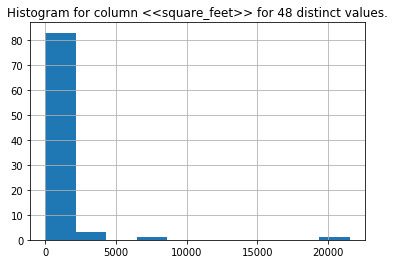

count       88.000000
mean      1214.102273
std       2388.797947
min         25.000000
25%        484.000000
50%        807.000000
75%       1292.000000
max      21528.000000
Name: square_feet, dtype: float64

In [7]:
v_data['square_feet'] = v_data['square_feet'].fillna(0)
v_square_feet = v_data[v_data['square_feet'] != 0]['square_feet'].reset_index(drop = True).sort_values()
v_square_feet.hist()
plt.title(f"Histogram for column <<square_feet>> for {v_square_feet.nunique()} distinct values.")
plt.show()
display(v_square_feet.describe())

We cannot use the values in this column, so we will just use the fact that there is a value provided or not, even if probably this column will not contain any usefull information.

In [8]:
v_data['square_feet'] = v_data['square_feet'].apply(lambda x: 1 if x > 0 else 0)

-----
##### 2.2.2. Process columns <<weekly_price>> and <<monthly_price>>

We will first check the distribution for the price, weekly price and monthly price.

In [9]:
display(v_data[['price', 'weekly_price', 'monthly_price']].describe())

,price,weekly_price,monthly_price
count,7402.000000,1532.000000,1224.000000
mean,68.747501,427.696475,1389.752451
std,147.273683,313.502712,997.925921
min,0.000000,70.000000,315.000000
25%,39.000000,250.000000,790.000000
50%,55.000000,350.000000,1110.000000
75%,80.000000,500.000000,1650.000000
max,8944.000000,5500.000000,9950.000000


As we can see there are prices range from 0 to 8944, so we will create bins for grouping the data and see its distribution (bins every 100 units).

Total number of properties: 7402. Bins every 100 units.


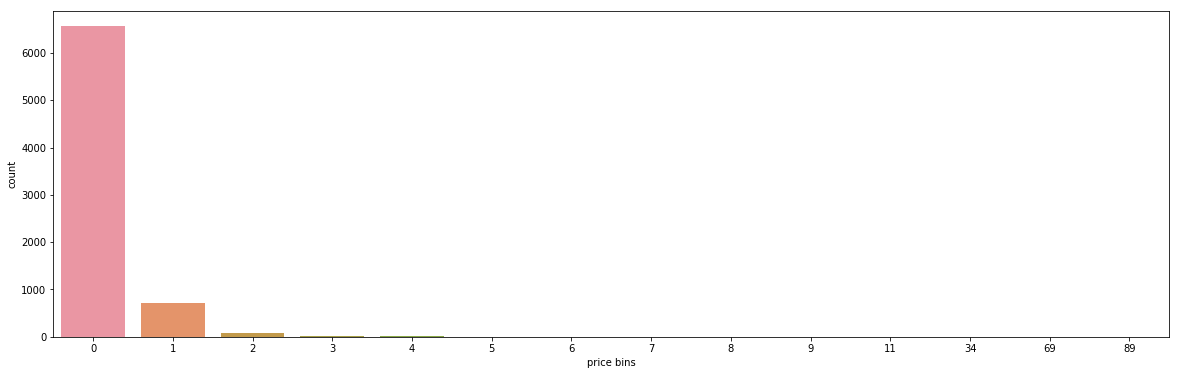

,price_count,price_min,price_max,price %
price bins,,,,
0,6566,0,100,0.887058
1,715,101,200,0.096596
2,77,207,300,0.010403
3,16,307,400,0.002162
4,11,420,500,0.001486
5,5,510,600,0.000675
6,2,650,681,0.000270
7,2,800,800,0.000270
8,1,850,850,0.000135


In [10]:
utl_displayPriceBins(v_data, 'price')

The fact that most of the values are under 600E, means that we should check all the values above in order to understand these outliers.

In [11]:
display(v_data[v_data['price'] > 600][['price', 'weekly_price', 'monthly_price', 'name']].sort_values('price'))

,price,weekly_price,monthly_price,name
898,650.0,5500.0,NaN,House with 7 bedrooms/ 7 bathrooms
367,681.0,625.0,2200.0,Sunny apartment near city centre
1951,800.0,3000.0,NaN,Grand-Place Luxury Residence
3336,800.0,NaN,NaN,Grand Place Residence a Luxury Historical Landmark
1567,850.0,850.0,850.0,Charming Aprt (Monthly) 9min to BXL
749,995.0,220.0,NaN,Private Room in Brussels
3814,1000.0,NaN,NaN,Hôtel particulier Jamaer
4119,1119.0,NaN,NaN,APPARTMENT NEAR EXPO-ATOMIUM&CENTER-STADIUM
5115,1200.0,NaN,NaN,Une péniche à Bruxelles
1327,3500.0,350.0,NaN,The best in brussels à partager


In [12]:
v_idx = 898
utl_displayUrlRow(v_data.loc[v_idx, ['id', 'name', 'price', 'weekly_price', 'monthly_price']])
v_return = utl_getURL(v_listing_url[v_idx])
# Checking on AirBNB we see that the price is not the same, so we correct it, the propery is also offering a weekly discount
v_data.loc[v_idx, 'price']         = 750
v_data.loc[v_idx, 'weekly_price']  = 4830

id: 4835809; name: House with 7 bedrooms/ 7 bathrooms; price: 650.0; weekly_price: 5500.0; monthly_price: nan; 
*****************************************************
https://www.airbnb.com/rooms/4835809
*** Path: ['meta_description']
Sep 16, 2018 - Entire home/apt for €650. Comfortable single-family home in the heart of Brussels, wi...
*** Path: ['title']
House with 7 bedrooms/ 7 bathrooms - Houses for Rent in Ixelles, Bruxelles, Belgium...


In [13]:
v_idx = 367
utl_displayUrlRow(v_data.loc[v_idx, ['id', 'name', 'price', 'weekly_price', 'monthly_price']])
v_return = utl_getURL(v_listing_url[v_idx])
# Checking on AirBNB we see that the price not the same, so we correct it, the propery is also offering a weekly and
# monthly discount
v_data.loc[v_idx, 'price']         = 59
v_data.loc[v_idx, 'weekly_price']  = v_data.loc[v_idx, 'price'] * 7
v_data.loc[v_idx, 'monthly_price'] = v_data.loc[v_idx, 'price'] * 30

id: 1899655; name: Sunny apartment near city centre; price: 681.0; weekly_price: 625.0; monthly_price: 2200.0; 
*****************************************************
https://www.airbnb.com/rooms/1899655
*** Path: ['meta_description']
Sep 16, 2018 - Entire home/apt for €681. 2 bedroom (incl. sheets/linen/covers &amp; towels) duplex w...
*** Path: ['title']
Sunny apartment near city centre - Apartments for Rent in Ixelles, Brussels, Belgium...


In [14]:
v_idx = 1951
utl_displayUrlRow(v_data.loc[v_idx, ['id', 'name', 'price', 'weekly_price', 'monthly_price']])
v_return = utl_getURL(v_listing_url[v_idx])
# Checking on AirBNB we see that the price is the same and the propery is also offering a weekly discount
v_data.loc[v_idx, 'weekly_price']  = round(v_data.loc[v_idx, 'price'] * 7 * 0.80)

id: 8585748; name: Grand-Place Luxury Residence; price: 800.0; weekly_price: 3000.0; monthly_price: nan; 
*****************************************************
https://www.airbnb.com/rooms/8585748
*** Path: ['meta_description']
Sep 16, 2018 - Entire home/apt for €800. Indulge yourself in one of the world famous houses on the m...
*** Path: ['title']
Grand-Place Luxury Residence - Houses for Rent in Bruxelles, Bruxelles, Belgium...


In [15]:
v_idx = 3336
utl_displayUrlRow(v_data.loc[v_idx, ['id', 'name', 'price', 'weekly_price', 'monthly_price']])
v_return = utl_getURL(v_listing_url[v_idx])
# Checking on AirBNB we see that the price is the same and the propery is also offering a weekly discount
v_data.loc[v_idx, 'weekly_price']  = round(v_data.loc[v_idx, 'price'] * 7 * 0.80)

id: 14767329; name: Grand Place Residence a Luxury Historical Landmark; price: 800.0; weekly_price: nan; monthly_price: nan; 
*****************************************************
https://www.airbnb.com/rooms/14767329
*** Path: ['meta_description']
Sep 16, 2018 - Entire home/apt for €800. This Residence is part of the lost memorable land mark of B...
*** Path: ['title']
Grand Place Residence a Luxury Historical Landmark - Townhouses for Rent in Bruxelles, Bruxelles, Be...


In [16]:
v_idx = 1567
utl_displayUrlRow(v_data.loc[v_idx, ['id', 'name', 'price', 'weekly_price', 'monthly_price']])
v_return = utl_getURL(v_listing_url[v_idx])
# Checking on AirBNB we see that the property cannot be reserved anymore, so I drop this record
v_data.drop(v_idx, axis = 0, inplace = True)

id: 7165868; name: Charming Aprt (Monthly) 9min to BXL; price: 850.0; weekly_price: 850.0; monthly_price: 850.0; 
*****************************************************
https://www.airbnb.com/rooms/7165868
*** Path: ['meta_description']
Sep 16, 2018 - Entire home/apt for €850. Our beautiful and fully furnished apartment is completely y...
*** Path: ['title']
Charming Aprt (Monthly) 9min to BXL - Apartments for Rent in Schaarbeek, Brussel, Belgium...


In [17]:
v_idx = 749
utl_displayUrlRow(v_data.loc[v_idx, ['id', 'name', 'price', 'weekly_price', 'monthly_price']])
v_return = utl_getURL(v_listing_url[v_idx])
# Checking on AirBNB we see that the price is the same, but the weekly_price is not correct so we recalculate it
v_data.loc[v_idx, 'weekly_price']  = round(v_data.loc[v_idx, 'price'] * 7 * 0.85)

id: 4134034; name: Private Room in Brussels; price: 995.0; weekly_price: 220.0; monthly_price: nan; 
*****************************************************
https://www.airbnb.com/rooms/4134034
*** Path: ['meta_description']
Sep 16, 2018 - Private room for €995. Bright comfortable twin bedroom with guest shower room and WC ...
*** Path: ['title']
Private Room in Brussels - Apartments for Rent in Ixelles, Brussels, Belgium...


In [18]:
v_idx = 3814
utl_displayUrlRow(v_data.loc[v_idx, ['id', 'name', 'price', 'weekly_price', 'monthly_price']])
v_return = utl_getURL(v_listing_url[v_idx])
# Checking on AirBNB we see that the price is the same

id: 16564081; name: Hôtel particulier  Jamaer; price: 1000.0; weekly_price: nan; monthly_price: nan; 
*****************************************************
https://www.airbnb.com/rooms/16564081
*** Path: ['meta_description']
Sep 16, 2018 - Private room for €1000.  A classified and historical house of the architect of the ci...
*** Path: ['title']
Hôtel particulier  Jamaer - Serviced apartments for Rent in Brussels, Brussels, Belgium...


In [19]:
v_idx = 4119
utl_displayUrlRow(v_data.loc[v_idx, ['id', 'name', 'price', 'weekly_price', 'monthly_price']])
v_return = utl_getURL(v_listing_url[v_idx])
# Checking on AirBNB we see that the price is the same

id: 17826895; name: APPARTMENT NEAR EXPO-ATOMIUM&CENTER-STADIUM; price: 1119.0; weekly_price: nan; monthly_price: nan; 
*****************************************************
https://www.airbnb.com/rooms/17826895
*** Path: ['meta_description']
Sep 16, 2018 - Entire home/apt for €1119.  Brand new apartment located in a private and supervised r...
*** Path: ['title']
APPARTMENT NEAR EXPO-ATOMIUM&amp;CENTER-STADIUM - Apartments for Rent in Jette, Brussels Hoofdstedel...


In [20]:
v_idx = 5115
utl_displayUrlRow(v_data.loc[v_idx, ['id', 'name', 'price', 'weekly_price', 'monthly_price']])
v_return = utl_getURL(v_listing_url[v_idx])
# Checking on AirBNB we see that the property is no longer available, so I drop this record
v_data.drop(v_idx, axis = 0, inplace = True)

id: 20816144; name: Une péniche à Bruxelles; price: 1200.0; weekly_price: nan; monthly_price: nan; 
*****************************************************
https://www.airbnb.com/rooms/20816144


In [21]:
v_idx = 1327
utl_displayUrlRow(v_data.loc[v_idx, ['id', 'name', 'price', 'weekly_price', 'monthly_price']])
v_return = utl_getURL(v_listing_url[v_idx])
# Checking on AirBNB we see that the price is the same, but I do suspect that someting is not correct in the encoding, so I 
# drop this record
v_data.drop(v_idx, axis = 0, inplace = True)

id: 6520633; name: The best in brussels à partager; price: 3500.0; weekly_price: 350.0; monthly_price: nan; 
*****************************************************
https://www.airbnb.com/rooms/6520633
*** Path: ['meta_description']
Sep 16, 2018 - Private room for €3500.  Splendid place of the best commune of the big Brussels!    A...
*** Path: ['title']
The best in brussels à partager - Houses for Rent in Woluwe-Saint Lambert , Bruxelles, Belgium...


In [22]:
v_idx = 4446
utl_displayUrlRow(v_data.loc[v_idx, ['id', 'name', 'price', 'weekly_price', 'monthly_price']])
v_return = utl_getURL(v_listing_url[v_idx])
# Checking on AirBNB we see that the price is the same

id: 18981232; name: Penhouse Suite in the Heart of Brussels; price: 7000.0; weekly_price: nan; monthly_price: nan; 
*****************************************************
https://www.airbnb.com/rooms/18981232
*** Path: ['meta_description']
Sep 16, 2018 - Private room for €7000. The premier suite in all of Belgium, the 250-square-metre Pen...
*** Path: ['title']
Penhouse Suite in the Heart of Brussels - Guest suites for Rent in Bruxelles, Bruxelles, Belgium...


In [23]:
v_idx = 3522
utl_displayUrlRow(v_data.loc[v_idx, ['id', 'name', 'price', 'weekly_price', 'monthly_price']])
v_return = utl_getURL(v_listing_url[v_idx])
# Checking on AirBNB we see that the property cannot be reserved anymore, so I drop this record
v_data.drop(v_idx, axis = 0, inplace = True)

id: 15617270; name: Chambre dans maison avec jardin; price: 8944.0; weekly_price: nan; monthly_price: nan; 
*****************************************************
https://www.airbnb.com/rooms/15617270
*** Path: ['meta_description']
Sep 16, 2018 - Private room for €8944. Chambre avec lit double dans une colocation à Anderlecht, la ...
*** Path: ['title']
Chambre dans maison avec jardin - Houses for Rent in Anderlecht, Bruxelles, Belgium...


------
We will also check the prices which are really small.

In [24]:
display(v_data[v_data['price'] < 10][['price', 'weekly_price', 'monthly_price', 'name']].sort_values('price'))

,price,weekly_price,monthly_price,name
4920,0.0,NaN,NaN,C&F Home
5004,0.0,NaN,NaN,Nice Apartment 1 to 6 people Brussel European
5006,0.0,NaN,NaN,Nice Apartment 1 to 6 people
5356,0.0,NaN,NaN,Nice 1 room apartment in EU area
4700,8.0,NaN,NaN,Nice studio to be shared in brussels


In [25]:
v_idx = 4920
utl_displayUrlRow(v_data.loc[v_idx, ['id', 'name', 'price', 'weekly_price', 'monthly_price']])
v_return = utl_getURL(v_listing_url[v_idx])
# Checking on AirBNB we see that the property is no longer available, so I drop this record
v_data.drop(v_idx, axis = 0, inplace = True)

id: 20220875; name: C&F Home; price: 0.0; weekly_price: nan; monthly_price: nan; 
*****************************************************
https://www.airbnb.com/rooms/20220875


In [26]:
v_idx = 5004
utl_displayUrlRow(v_data.loc[v_idx, ['id', 'name', 'price', 'weekly_price', 'monthly_price']])
v_return = utl_getURL(v_listing_url[v_idx])
# Checking on AirBNB we see that the price not the same, so we correct it
v_data.loc[v_idx, 'price']         = 65

id: 20468188; name: Nice Apartment 1 to 6 people Brussel European; price: 0.0; weekly_price: nan; monthly_price: nan; 
*****************************************************
https://www.airbnb.com/rooms/20468188
*** Path: ['meta_description']
Sep 16, 2018 - Entire home/apt for €0.  Very nice apartment with private terrace. Entrance hall, liv...
*** Path: ['title']
Apartment in Brussels - Condominiums for Rent in Bruxelles, Bruxelles, Belgium...


In [27]:
v_idx = 5006
utl_displayUrlRow(v_data.loc[v_idx, ['id', 'name', 'price', 'weekly_price', 'monthly_price']])
v_return = utl_getURL(v_listing_url[v_idx])
# Checking on AirBNB we see that the price not the same, so we correct it
v_data.loc[v_idx, 'price']         = 70

id: 20468876; name: Nice Apartment 1 to 6 people; price: 0.0; weekly_price: nan; monthly_price: nan; 
*****************************************************
https://www.airbnb.com/rooms/20468876
*** Path: ['meta_description']
Sep 16, 2018 - Entire home/apt for €0.  Very nice apartment with private terrace. Entrance hall, liv...
*** Path: ['title']
Apartment 8th floor in Brussels - Apartments for Rent in Bruxelles, Bruxelles, Belgium...


In [28]:
v_idx = 5356
utl_displayUrlRow(v_data.loc[v_idx, ['id', 'name', 'price', 'weekly_price', 'monthly_price']])
v_return = utl_getURL(v_listing_url[v_idx])
# Checking on AirBNB we see that the price not the same, so we correct it
v_data.loc[v_idx, 'price']         = 70

id: 21412329; name: Nice 1 room apartment in EU area; price: 0.0; weekly_price: nan; monthly_price: nan; 
*****************************************************
https://www.airbnb.com/rooms/21412329
*** Path: ['meta_description']
Sep 16, 2018 - Entire home/apt for €0. This place will make you feel expensive by how it is nicely d...
*** Path: ['title']
Nice 1 room apartment in EU area - Apartments for Rent in Bruxelles, Bruxelles, Belgium...


In [29]:
v_idx = 4700
utl_displayUrlRow(v_data.loc[v_idx, ['id', 'name', 'price', 'weekly_price', 'monthly_price']])
v_return = utl_getURL(v_listing_url[v_idx])
# Checking on AirBNB we see that the property is no longer available, so I drop this record
v_data.drop(v_idx, axis = 0, inplace = True)

id: 19675852; name: Nice studio to be shared in brussels; price: 8.0; weekly_price: nan; monthly_price: nan; 
*****************************************************
https://www.airbnb.com/rooms/19675852
*** Path: ['meta_description']
Sep 16, 2018 - Shared room for €20. Small studio to be shared ** It is small, no separate rooms; you...
*** Path: ['title']
Nice studio to be shared in brussels - Apartments for Rent in Ixelles, Bruxelles, Belgium...


----
**Q1: Renting for a longer period is always cheaper?**

Display again the distribution for the prices (bins every 100 units).

Total number of properties: 7396. Bins every 100 units.


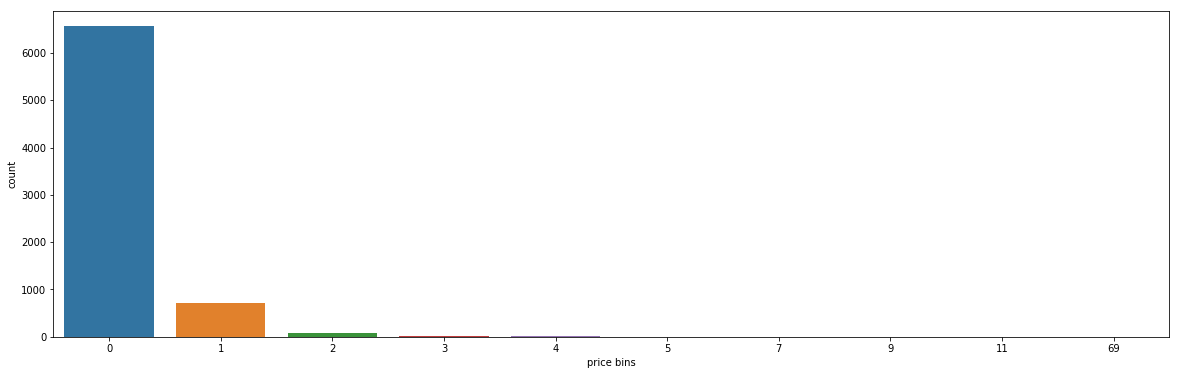

,price_count,price_min,price_max,price %
price bins,,,,
0,6565,10,100,0.887642
1,715,101,200,0.096674
2,77,207,300,0.010411
3,16,307,400,0.002163
4,11,420,500,0.001487
5,5,510,600,0.000676
7,3,750,800,0.000406
9,2,995,1000,0.000270
11,1,1119,1119,0.000135


In [30]:
utl_displayPriceBins(v_data, 'price')

----------------
For the weekly price we will check the distribution (bins every 100 units).

Total number of properties: 1531. Bins every 500 units.


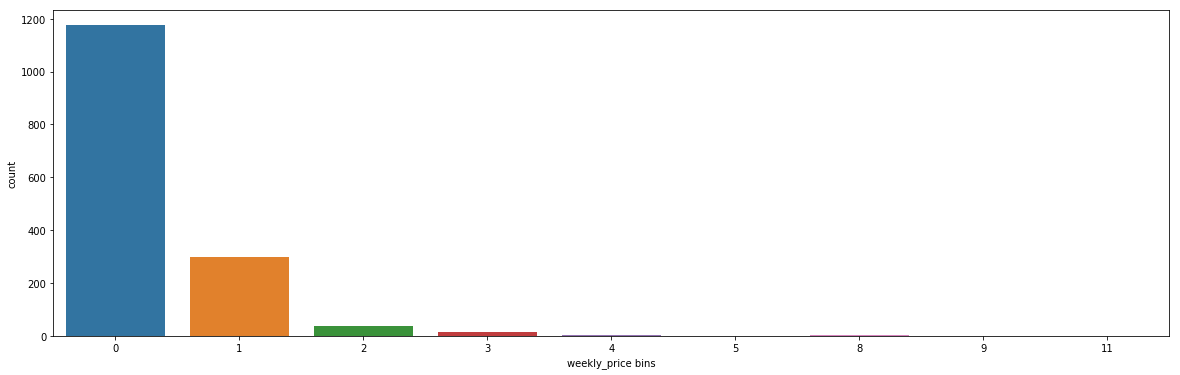

,weekly_price_count,weekly_price_min,weekly_price_max,weekly_price %
weekly_price bins,,,,
0,1175,70,500,0.767472
1,297,510,1000,0.193991
2,38,1042,1500,0.024820
3,14,1600,1955,0.009144
4,2,2250,2300,0.001306
5,1,3000,3000,0.000653
8,2,4480,4480,0.001306
9,1,4830,4830,0.000653
11,1,5920,5920,0.000653


In [31]:
utl_displayPriceBins(v_data, 'weekly_price', 500)

Total number of properties: 1531


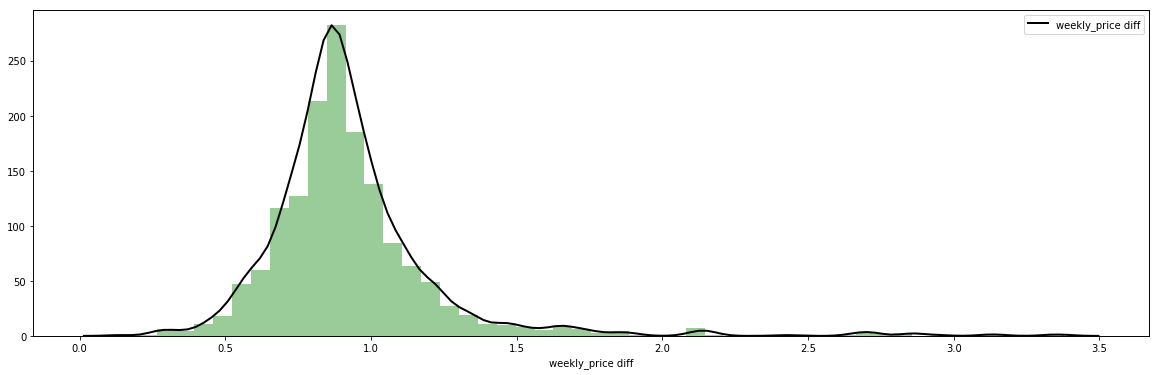

,weekly_price diff,"(0.0, 0.5]","(0.5, 0.6]","(0.6, 0.8]","(0.8, 1.0]","(1.0, 1.2]","(1.2, 1.5]","(1.5, 2.0]","(2.0, 3.0]","(3.0, 6.0]"
weekly_price diff,count,33,70,344,703,226,99,33,19,4


In [32]:
utl_compWMPriceDiff(v_data, 'weekly')

In the results above we can see that for **381 properties** renting and paying for the property for a complete week is **more expensive** than paying for 7 days.

---
For the monthly price we check the distribution (bins every 500 units).

Total number of properties: 1223. Bins every 1000 units.


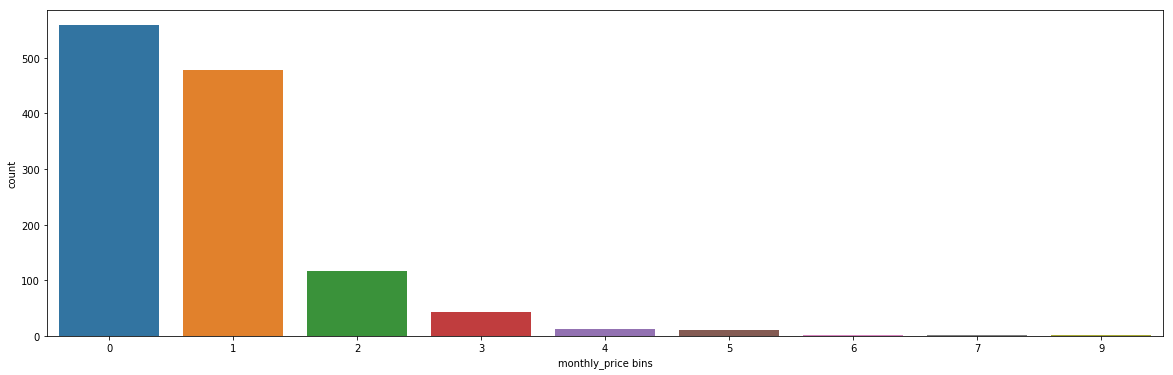

,monthly_price_count,monthly_price_min,monthly_price_max,monthly_price %
monthly_price bins,,,,
0,558,315,1000,0.456255
1,478,1029,2000,0.390842
2,116,2058,3000,0.094849
3,43,3100,4000,0.035159
4,12,4200,5000,0.009812
5,11,5040,6000,0.008994
6,2,6500,6741,0.001635
7,1,7500,7500,0.000818
9,2,9800,9950,0.001635


In [33]:
utl_displayPriceBins(v_data, 'monthly_price', 1000)

Total number of properties: 1223


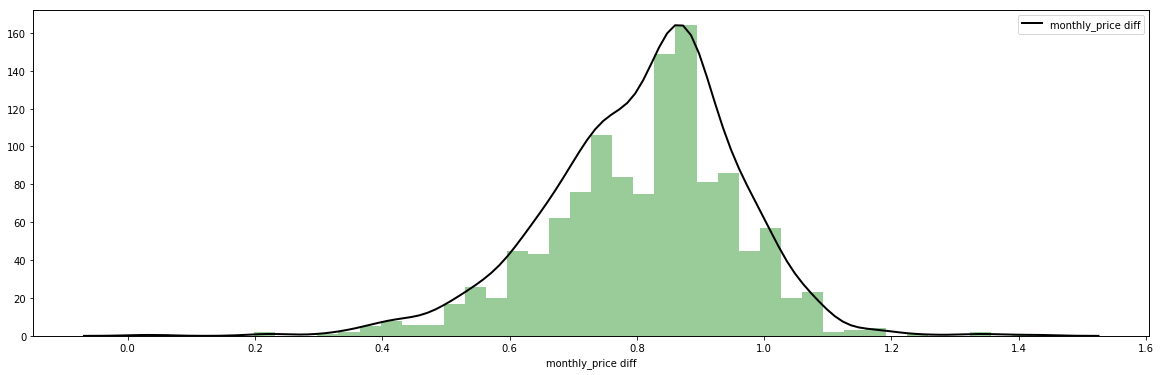

,monthly_price diff,"(0.0, 0.5]","(0.5, 0.6]","(0.6, 0.8]","(0.8, 1.0]","(1.0, 1.2]","(1.2, 1.5]","(1.5, 2.0]","(2.0, 3.0]","(3.0, 6.0]"
monthly_price diff,count,41,59,431,620,68,4,0,0,0


In [34]:
utl_compWMPriceDiff(v_data, 'monthly')

In the results above we can see that for **72 properties** renting and paying for the property for a complete month is **more expensive** than paying for 4 weeks.

-------
We check the properties for which we have the biggest difference in the weekly price:

In [35]:
display( v_data[['price', 'weekly_price', 'monthly_price', 'weekly_price diff', 'monthly_price diff']]
           .sort_values('weekly_price diff', ascending = False).head(10) )

,price,weekly_price,monthly_price,weekly_price diff,monthly_price diff
2083,55.0,1300.0,4500.0,3.376623,0.865385
2086,60.0,1400.0,4500.0,3.333333,0.803571
2085,68.0,1500.0,5000.0,3.151261,0.833333
1275,55.0,1200.0,3500.0,3.116883,0.729167
1280,68.0,1400.0,4500.0,2.941176,0.803571
2084,85.0,1700.0,5500.0,2.857143,0.808824
1277,60.0,1200.0,3500.0,2.857143,0.729167
1274,60.0,1200.0,3500.0,2.857143,0.729167
1273,68.0,1300.0,4000.0,2.731092,0.769231
1276,68.0,1300.0,4000.0,2.731092,0.769231


We see that the weekly and montly price follow a normal trend, so we will assume that the owner prefers having people stay for a day rather than for a long period.

For all the propertis for which there was not a weekly / monthly price specified, we will assume that there will be no discount / no increase in the price. We will set the weekly_price diff and monthly_price diff to 1 and drop the columns weekly_price and monthly_price.

In [36]:
v_data.loc[v_data[v_data['weekly_price'].isnull()].index,  'weekly_price diff']  = 1
v_data.loc[v_data[v_data['monthly_price'].isnull()].index, 'monthly_price diff'] = 1
v_data.drop(['weekly_price', 'monthly_price'], axis = 1, inplace = True)

----
### 3. Process object columns

For the columns that only have 2 values, we will reencode them as a boolean contaning values 1 or 0.

In [37]:
v_values = v_data.nunique()
v_columns = []
for item in v_data.select_dtypes(include = 'object').columns:
    v_values = v_data[item].value_counts()
    if v_values.shape[0] == 2:
        v_values = v_values.index.tolist()
        v_data[item] = v_data[item].map({v_values[0]: 0, v_values[1]: 1}).astype(int)
    elif v_values.shape[0] < 10:
        v_columns.append(item)
        display(pd.DataFrame({v_values.name: v_values.index.tolist(), 'values': v_values.values.tolist()}).T)

,0,1,2,3
host_response_time,within an hour,within a few hours,within a day,a few days or more
values,3140,1100,928,165


,0,1,2,3,4,5
market,Brussels,Paris,Other (International),Grande-Terre,Chalkidiki,Upper Normandy
values,7378,2,2,1,1,1


,0,1,2
room_type,Entire home/apt,Private room,Shared room
values,4789,2528,79


,0,1,2,3,4
bed_type,Real Bed,Pull-out Sofa,Futon,Couch,Airbed
values,7217,127,31,17,4


,0,1,2,3
cancellation_policy,flexible,moderate,strict_14_with_grace_period,super_strict_30
values,3073,2300,2019,4


Column << market >> contains almost all the values for Brussels, so we will just reencode it as Brussels / no Brussels.

In [38]:
v_data['market'] = v_data['market'].apply(lambda x: 1 if x == 'Brussels' else 0).astype(int)

Dummy encode the columns that have less than 10 distinct values type.

In [39]:
display(v_columns)
v_data = pd.get_dummies( v_data, columns = v_columns, dummy_na = True, prefix_sep = '_' )

['host_response_time',
 'market',
 'room_type',
 'bed_type',
 'cancellation_policy']

We drop the following columns: <<picture_url; host_name>>

In [40]:
v_data.drop(['picture_url', 'host_name', 'host_id'], axis = 1, inplace = True)

We transform column <<property_type>> by dummy encode.

In [41]:
v_data = pd.get_dummies( v_data, columns = ['property_type'], dummy_na = True, prefix_sep = '_' )

We transform columns <<host_since; first_review; last_review>> to contain the number of months the host is active until 01/01/2019.

We transform column <<host_response_rate>> from percentage to a number between 0 and 1.

We transform columns <<cleaning_fee; security_deposit; extra_people>> to float.

In [42]:
v_data['host_since']   = pd.to_datetime(v_data['host_since'])
v_data['first_review'] = pd.to_datetime(v_data['first_review'])
v_data['last_review']  = pd.to_datetime(v_data['last_review'])
v_data = v_data.assign( host_since = (2019 - v_data.host_since.dt.year) * 12 + (1 - v_data.host_since.dt.month),
                        first_review = (2019 - v_data.first_review.dt.year) * 12 + (1 - v_data.first_review.dt.month),
                        last_review = (2019 - v_data.last_review.dt.year) * 12 + (1 - v_data.last_review.dt.month),
                        host_response_rate = v_data.host_response_rate.str.replace('%', '').astype(float) / 100,
                        cleaning_fee = v_data.cleaning_fee.str.replace('$', '').astype(float),
                        security_deposit = v_data.security_deposit.str.extract('\$(.*)', expand = False)
                                                                  .str.replace(',', '').astype(float),
                        extra_people = v_data.extra_people.str.replace('$', '').astype(float), )

We will assume that if no security deposit was specified, than none is being asked, so we will set this column to 0.

In [43]:
v_data.loc[v_data[v_data['security_deposit'].isnull()].index, 'security_deposit'] = 0

----
Check the rows where column << bathrooms >> is not specified.

We will use the column << accommodates >> in order to fill column << bathrooms >>. We will suppose that if there are less than 3 people that are being hosted, than only one bathroom will be available. For all the other values we will use the mean value for properties that have the same number of people that can be hosted.

In [44]:
display(v_data[v_data['bathrooms'].isnull()][['bathrooms', 'bedrooms', 'beds', 'accommodates']])

v_column = 'bathrooms'
v_idx = v_data[(v_data[v_column].isnull()) & (v_data['accommodates'] < 3) ].index
v_data.loc[v_idx, v_column] = 1
v_data.loc[v_idx, 'beds'] = 1

v_idx = v_data[(v_data[v_column].isnull()) & (v_data['accommodates'] == 16) ].index
v_data.loc[v_idx, v_column] = round(v_data[~(v_data[v_column].isnull()) & (v_data['accommodates'] == 16)][v_column].mean())

,bathrooms,bedrooms,beds,accommodates
31,NaN,1.0,1.0,2
78,NaN,1.0,NaN,2
100,NaN,1.0,1.0,1
182,NaN,3.0,NaN,1
331,NaN,10.0,16.0,16


----
Check the rows where column << bedrooms >> is not specified. 

We will use the column << accommodates >> in order to fill column << bedrooms >>. We will use the mean value for properties that have the same number of people that can be hosted.

In [45]:
display(v_data[v_data['bedrooms'].isnull()][['bathrooms', 'bedrooms', 'beds', 'accommodates']])

v_column = 'bedrooms'
v_idx = v_data[(v_data[v_column].isnull()) & (v_data['accommodates'] == 2) ].index
v_data.loc[v_idx, v_column] = round(v_data[~(v_data[v_column].isnull()) & (v_data['accommodates'] == 2)][v_column].mean())

,bathrooms,bedrooms,beds,accommodates
597,1.0,NaN,1.0,2
3988,1.0,NaN,NaN,2


----
Check the rows where column << beds >> is not specified.

We will use the column << accommodates >> in order to fill column << beds >>. We will use the mean value for properties that have the same number of people that can be hosted.

In [46]:
display(v_data[v_data['beds'].isnull()][['bathrooms', 'bedrooms', 'beds', 'accommodates']])

v_column = 'beds'
v_idx = v_data[(v_data[v_column].isnull()) & (v_data['accommodates'] == 2) ].index
v_data.loc[v_idx, v_column] = round(v_data[~(v_data[v_column].isnull()) & (v_data['accommodates'] == 2)][v_column].mean())

,bathrooms,bedrooms,beds,accommodates
1102,1.0,1.0,NaN,2
3988,1.0,1.0,NaN,2


-------
Calculate the number of days since the last update for the calendar. If no date is specified, we will set the value to 365.

In [47]:
v_calendar_updated = pd.DataFrame(v_data['calendar_updated'].str.replace(' ago', ''))
v_calendar_updated['days']   = v_calendar_updated['calendar_updated'].apply(lambda x: x.replace('days', '') 
                                                                                         if  'days' in x else 0 ).astype(int)
v_calendar_updated['weeks']  = v_calendar_updated['calendar_updated'].apply(lambda x: x.replace('weeks', '') 
                                                                                         if  'weeks' in x else 0 ).astype(int)
v_calendar_updated['months'] = v_calendar_updated['calendar_updated'].apply( lambda x: x.replace('months', '') 
                                                                                         if 'months' in x else 0 ).astype(int)
v_idx = v_calendar_updated[v_calendar_updated['calendar_updated'] == 'yesterday'].index
v_calendar_updated.loc[v_idx, 'days'] = 1

v_idx = v_calendar_updated[v_calendar_updated['calendar_updated'] == 'a week'].index
v_calendar_updated.loc[v_idx, 'days'] = 7

v_idx = v_calendar_updated[v_calendar_updated['calendar_updated'] == '1 week'].index
v_calendar_updated.loc[v_idx, 'days'] = 7

v_idx = v_calendar_updated[v_calendar_updated['calendar_updated'] == '1 month'].index
v_calendar_updated.loc[v_idx, 'days'] = 30

v_idx = v_calendar_updated[v_calendar_updated['calendar_updated'] == 'never'].index
v_calendar_updated.loc[v_idx, 'days'] = 365

v_data['calendar_updated'] = v_calendar_updated['days'] + 7 * v_calendar_updated['weeks'] + 30 * v_calendar_updated['months']

--------
We process column << host_verifications >>. The data is given as a list, so we will create a dataset with all the possiblie values and set to 1 those values which are specified in the list.

In [48]:
display(v_data['host_verifications'].head(3))
v_host_verifications = pd.DataFrame({'key': 'a'}, index = [0])
for item in v_data['host_verifications'].value_counts().index:
    v_host = {f'Host_Verification_{value}': 1 for value in item[1 : -1].replace("'", '').split(',')}
    v_host = pd.DataFrame.from_dict(orient = 'index', data = v_host).T
    v_host['key'] = item
    v_host_verifications = pd.concat([v_host_verifications, v_host], axis = 0, sort = False)

v_host_verifications = v_host_verifications.fillna(0).reset_index(drop = True)

v_data = v_data.merge(v_host_verifications, how = 'left', left_on = 'host_verifications', right_on = 'key')
v_data.drop(['host_verifications', 'key'], axis = 1, inplace = True)

0                              ['email', 'phone', 'reviews']
1                              ['email', 'phone', 'reviews']
2    ['email', 'phone', 'reviews', 'jumio', 'government_id']
Name: host_verifications, dtype: object

--------
Clean data linked to reviews. 

If no first review was provided, than set the number of reviews to zero. For all the properties where there is no review provided, set the linked columns to zero.


In [49]:
v_data.loc[v_data[v_data['first_review'].isnull()].index, 'number_of_reviews'] = 0
v_data.loc[v_data[v_data['first_review'] == 0].index, 'number_of_reviews'] = 0
v_idx = v_data[v_data['number_of_reviews'] == 0].index
v_data.loc[v_idx, [ 'first_review', 'last_review', 'review_scores_rating', 
                    'review_scores_accuracy', 'review_scores_cleanliness',
                    'review_scores_checkin', 'review_scores_communication',
                    'review_scores_location', 'review_scores_value', 'reviews_per_month' ]] = 0
g_checkPoint = v_data.copy()

In [50]:
v_data = g_checkPoint.copy()
v_cols = [ 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
           'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
           'review_scores_value' ]
v_data[v_cols] = Imputer().fit_transform(v_data[v_cols])

-----
Process columns << zipcode; neighbourhood; city; state >>.

First we drop the rows for which we don't have a correct zipcode.

In [51]:
v_data = v_data[v_data['zipcode'] != 'Xxx']

We read in a csv file that contains the correct mapping for the neighbourhoods in Bruxelles.

In [52]:
v_citiesBruxelles = pd.read_csv('BruxellesNeighbourhoods.csv', sep = ';')
display(v_citiesBruxelles.head())

,key,zipcode,neighbourhood,city,state
0,1070_Anderlecht,1070,Anderlecht,Anderlecht,Region de Bruxelles-Capitale
1,1070_Molenbeek-Saint-Jean,1070,Anderlecht,Anderlecht,Region de Bruxelles-Capitale
2,1070_None,1070,Anderlecht,Anderlecht,Region de Bruxelles-Capitale
3,1000_Anneessens,1000,Anneessens,Bruxelles,Bruxelles
4,1160_Auderghem,1160,Auderghem,Auderghem,Region de Bruxelles-Capitale


In [53]:
v_neighbour = v_data[['zipcode', 'neighbourhood', 'city', 'state']].fillna('None').copy()
v_neighbour['key'] = v_neighbour['zipcode'] + '_' + v_neighbour['neighbourhood']
v_neighbour = v_neighbour.merge(v_citiesBruxelles, how = 'left', on = 'key')

# Check that all codes are mapped
display(v_neighbour[v_neighbour['zipcode_y'].isnull()].sort_values('key'))

v_data['zipcode'] = v_neighbour['zipcode_y'].astype(int)
v_data['neighbourhood'] = v_neighbour['neighbourhood_y']
v_data['city'] = v_neighbour['city_y']
v_data['state'] = v_neighbour['state_y']

,zipcode_x,neighbourhood_x,city_x,state_x,key,zipcode_y,neighbourhood_y,city_y,state_y


We transform column <<state; city>> by dummy encode.

We drop the following columns: <<zipcode; neighbourhood_cleansed>>

In [54]:
v_data['city'] = v_data['zipcode'].astype(str) + ' ' + v_data['city']
v_data = pd.get_dummies( v_data, columns = ['state', 'city'], dummy_na = False, prefix_sep = '_' )
v_data.drop(['zipcode', 'neighbourhood_cleansed', 'street', 'smart_location'], axis = 1, inplace = True)
g_checkPoint_City = v_data.copy()

**Q2: Where can I rent a property?**

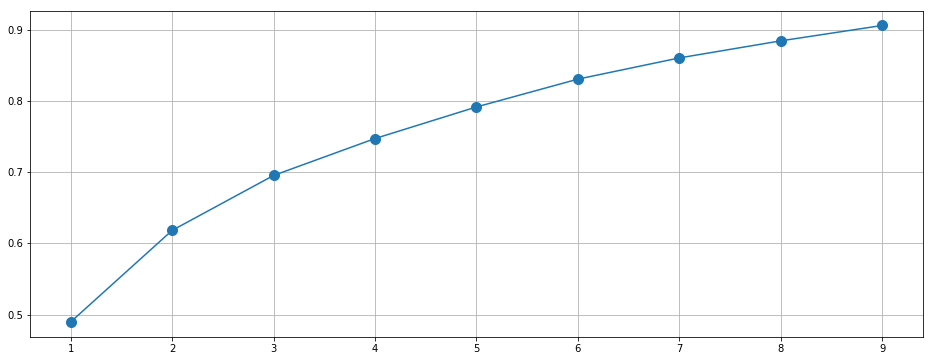

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
Cumulated Variance,0.4896,0.6183,0.6955,0.7474,0.7918,0.8309
Component Variance,0.4896,0.1287,0.0772,0.0519,0.0444,0.0391


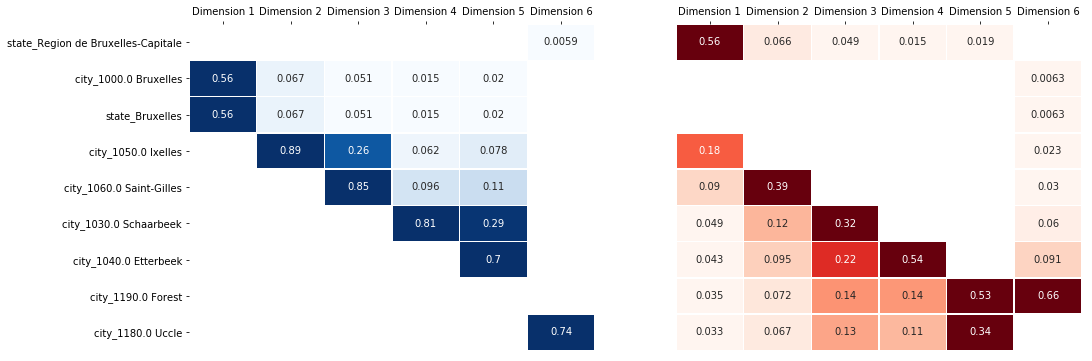

In [55]:
v_data = g_checkPoint_City.copy()
v_cols = [item for item in v_data.columns if 'state' in item]
v_cols.extend([item for item in v_data.columns if 'city' in item])
_, _ = utl_displayPCAResults( p_data     = v_data[v_cols], 
                              p_scaler   = None,
                              p_colName  = 'City ', 
                              p_percent  = 0.9, 
                              p_comp_no  = 6,
                              p_no       = 11,
                              p_figsize  = 6 )

From the plot avove we can see that only 6 profiles can cover 83% of the available properties for renting and 9 profiles cover 90% of the available properties:
  - 48% of the properties are in Brussels city situated outside of the extended Brussels-Capital Region
  - 12.87% of the properties are mainly in Ixelles
  - 7% of the properties are mainly in Saint-Gilles
  - 5% of the properties are mainly in Schaarbeek
  - 4,5% of the properties are mainly in Etterbeek
  - 4% of the properties are mainly in Uccle

----
We process column << amenities >>.

In [56]:
v_amenities = pd.DataFrame()
for item in v_data['amenities'].value_counts().index:
    v_amenity = {f'Amenity_{value}': 1 for value in item[1 : -1].replace('"', '').split(',')}
    v_amenity = pd.DataFrame.from_dict(orient = 'index', data = v_amenity).T
    v_amenity['key'] = item
    v_amenities = pd.concat([v_amenities, v_amenity], axis = 0, sort = False)

v_amenities = v_amenities.fillna(0).reset_index(drop = True)
v_amenities.drop('Amenity_', axis = 1, inplace = True)

v_data = v_data.merge(v_amenities, how = 'left', left_on = 'amenities', right_on = 'key')
v_data.drop(['amenities', 'key'], axis = 1, inplace = True)
g_checkPoint_Amenity = v_data.copy()

**Q3: Which are the main amenities proposed in the properties available for renting?**

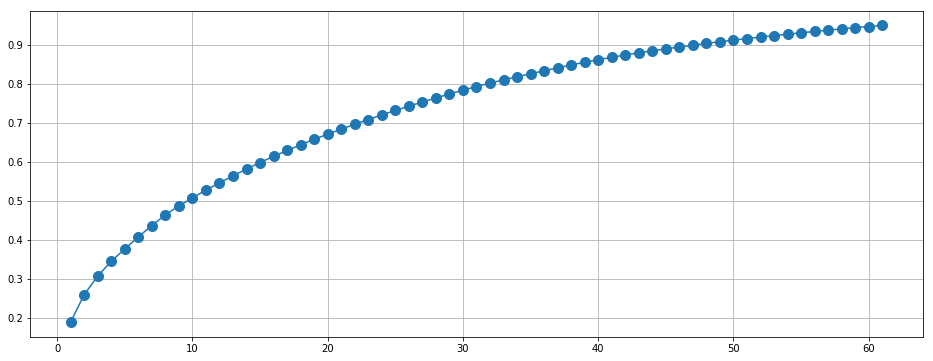

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
Cumulated Variance,0.1886,0.2589,0.3066,0.3448,0.3764,0.4073
Component Variance,0.1886,0.0703,0.0477,0.0382,0.0316,0.0309


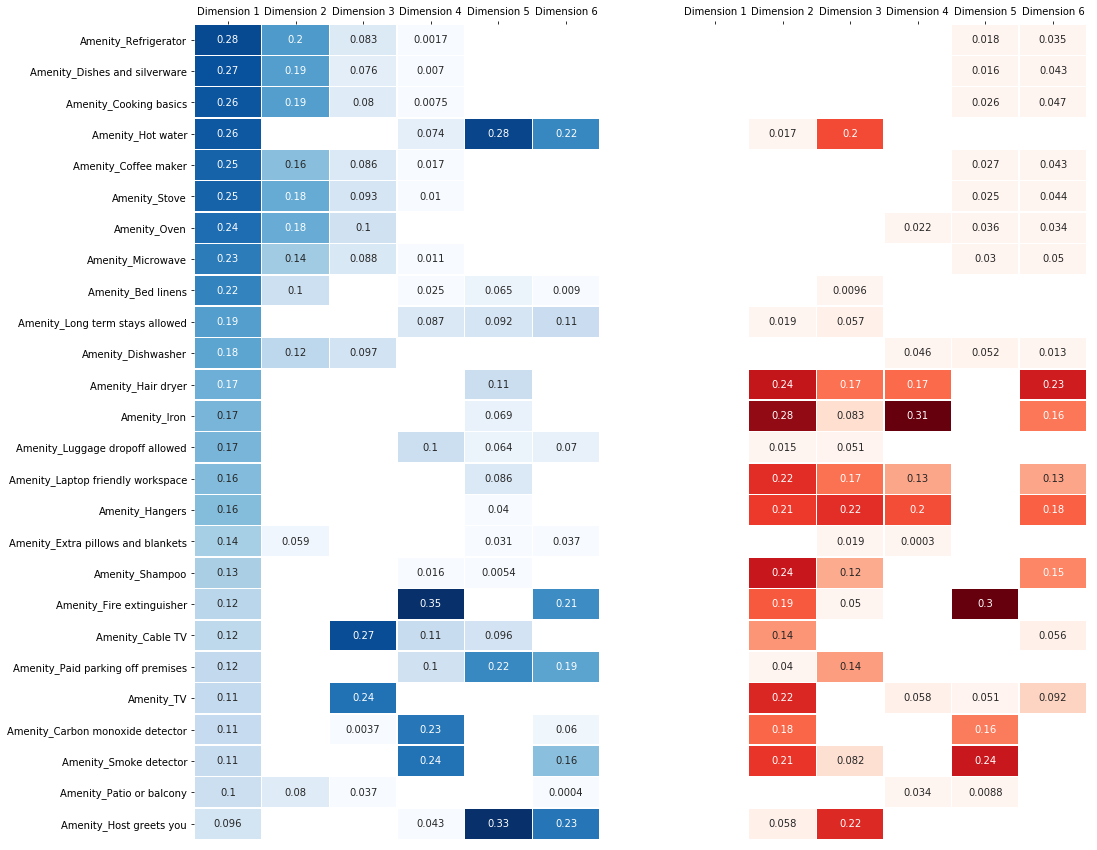

In [57]:
v_data = g_checkPoint_Amenity.copy()
v_cols = [item for item in v_data.columns if 'Amenity_' in item]
_, _ = utl_displayPCAResults( p_data    = v_data[v_cols], 
                              p_scaler  = None,
                              p_colName = 'Amenity ', 
                              p_percent = 0.95, 
                              p_comp_no = 6,
                              p_no      = 28,
                              p_figsize = 15 )

As we can see in the plot above, for 95% of the properties we can create 60 different profiles.

The first 6 profiles can be found in 40.73% of cases.

The most common profile can be found in 18.86% of cases and it usually has:
   - a refrigerator
   - dishes and silverware
   - cooking basics
   - hot water
   - coffee maker
   - stove
   - etc

The second most common profile, than can be found in 7% of cases, is interesting for rather what it doesn't usually have:
   - hair dryer
   - iron
   - laptop friendly workspace
   - hangers
   - shampoo
   - TV
   - etc

-------------------
We process column << host_location >>.

In [58]:
v_host_location = pd.DataFrame()
for item in v_data['host_location'].value_counts().index:
    v_values = item.split(',')
    v_host = {}
    v_host['Host_Location_Country'] = v_values[-1]
    if len(v_values) > 1: v_host['Host_Location_State'] = v_values[-2]
    if len(v_values) > 2: v_host['Host_Location_City']  = v_values[-3]
    if len(v_values) > 3: display(item)
    
    v_host = pd.DataFrame.from_dict(orient = 'index', data = v_host).T
    v_host['key'] = item
    v_host_location = pd.concat([v_host_location, v_host], axis = 0, sort = False)

v_host_location.reset_index(drop = True, inplace = True)

with open('mapCountry.json') as file:
    v_map = json.load(file)
v_host_location['Host_Location_Country'] = v_host_location['Host_Location_Country'].str.strip().replace(v_map)

with open('mapRegion.json') as file:
    v_map = json.load(file)
v_host_location['Host_Location_StateRep'] = v_host_location['Host_Location_State'].str.strip().replace(v_map)
v_host_location['Host_Location_State'] = 'Country District'
v_idx = v_host_location[v_host_location['Host_Location_Country'].isin(['Belgium', 'France'])].index
v_host_location.loc[v_idx, 'Host_Location_State'] = v_host_location.loc[v_idx, 'Host_Location_StateRep']
v_host_location.drop(['Host_Location_City', 'Host_Location_StateRep'], inplace = True, axis = 1)
v_host_location = pd.get_dummies( v_host_location, 
                                  columns = ['Host_Location_Country', 'Host_Location_State'], 
                                  dummy_na = False, 
                                  prefix_sep = '_' )

v_data = v_data.merge(v_host_location, how = 'left', left_on = 'host_location', right_on = 'key')
v_data.drop(['host_location', 'key'], axis = 1, inplace = True)
g_checkPoint_HostLocation = v_data.copy()
display(v_data.shape)

(7395, 364)

**Q4: Which are the main profiles for the people that propose to rent a property in Bruxelles?**

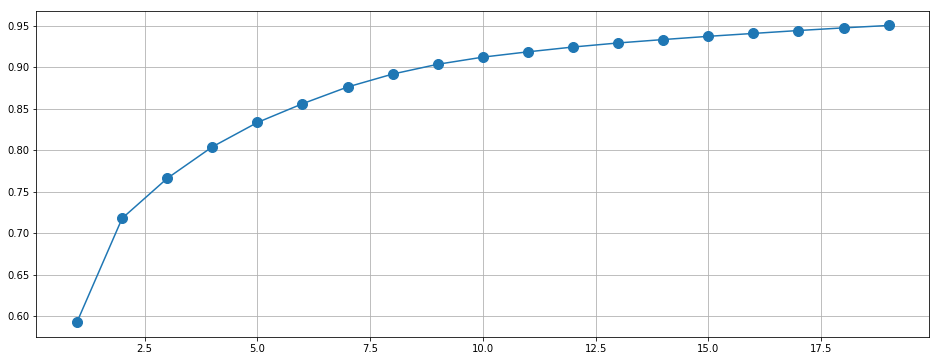

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
Cumulated Variance,0.5929,0.7179,0.7661,0.8041,0.8335,0.8561
Component Variance,0.5929,0.1250,0.0482,0.0380,0.0294,0.0226


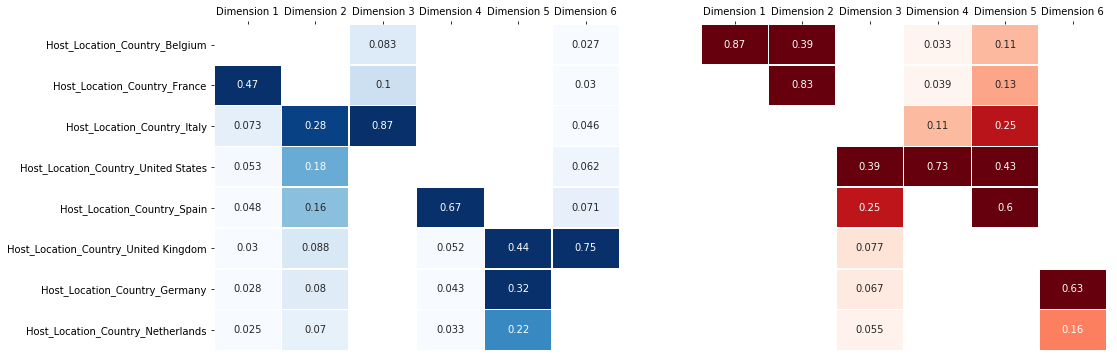

In [59]:
v_data = g_checkPoint_HostLocation.copy()
v_cols = [item for item in v_data.columns if 'Host_Location_Country' in item]
_, _ = utl_displayPCAResults( p_data     = v_data[v_cols], 
                              p_scaler   = None,
                              p_colName  = 'HostLocCtry ', 
                              p_percent  = 0.95, 
                              p_comp_no  = 6,
                              p_no       = 10,
                              p_figsize  = 6 )

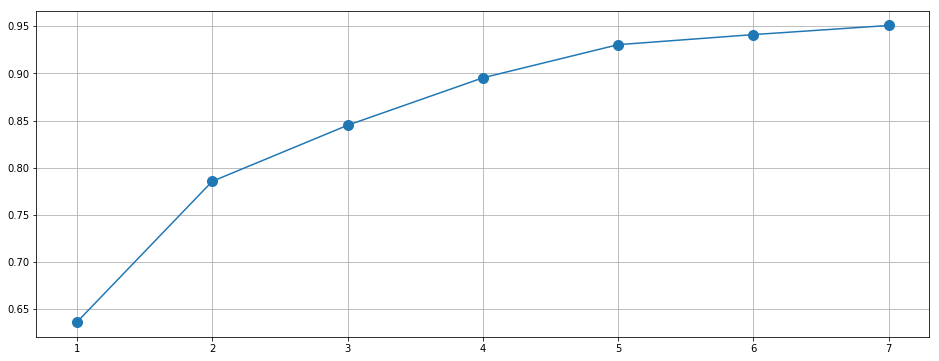

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
Cumulated Variance,0.6361,0.7855,0.8450,0.8954,0.9306,0.9413
Component Variance,0.6361,0.1494,0.0595,0.0504,0.0352,0.0107


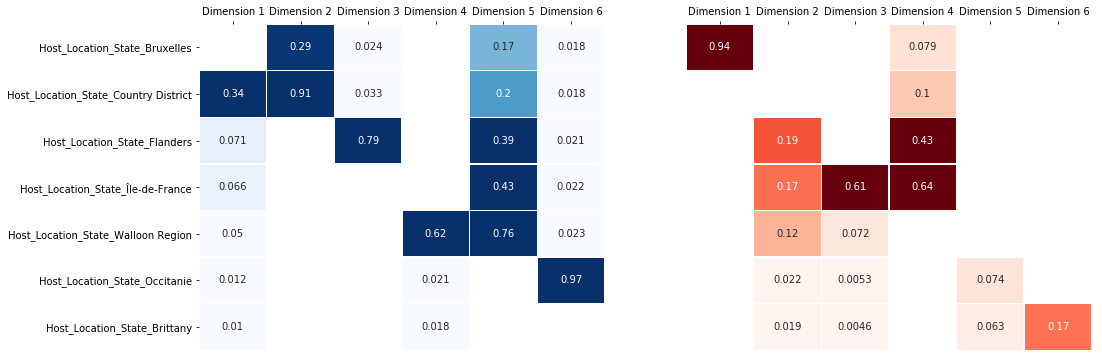

In [60]:
v_cols = [item for item in v_data.columns if 'Host_Location_State' in item]
_, _ = utl_displayPCAResults( p_data     = v_data[v_cols], 
                              p_scaler   = None,
                              p_colName  = 'HostLocState ', 
                              p_percent  = 0.95, 
                              p_comp_no  = 6,
                              p_no       = 9,
                              p_figsize  = 6 )

As we can see in the plot above, for 95% of the hosts can be split in 7 profiles, based on their location.
   - 63.61% of hosts are not from Brussels
   - 14.94% of hosts are from outside Belgium or France
   - 6% of hosts are from Flanders 
   - 5% of hosts are from Wallonia

----
Process column << host_about >>.

In [61]:
v_data['host_about'] = v_data['host_about'].apply(lambda x: 0 if x is np.NaN else 1)
display(v_data['host_about'].value_counts())

1    3783
0    3612
Name: host_about, dtype: int64

----
Process column << house_rules >>.

In [62]:
v_data['house_rules'] = v_data['house_rules'].apply(lambda x: 0 if x is np.NaN else 1)
display(v_data['house_rules'].value_counts())

0    3909
1    3486
Name: house_rules, dtype: int64

----
Process column << interaction >>.

In [63]:
v_data['interaction'] = v_data['interaction'].apply(lambda x: 0 if x is np.NaN else 1)
display(v_data['interaction'].value_counts())

0    3864
1    3531
Name: interaction, dtype: int64

----
Process column << neighborhood_overview >>.

In [64]:
v_data['neighborhood_overview'] = v_data['neighborhood_overview'].apply(lambda x: 0 if x is np.NaN else 1)
display(v_data['neighborhood_overview'].value_counts())

1    4194
0    3201
Name: neighborhood_overview, dtype: int64

----
Process column << notes >>.

In [65]:
v_data['notes'] = v_data['notes'].apply(lambda x: 0 if x is np.NaN else 1)
display(v_data['notes'].value_counts())

0    4926
1    2469
Name: notes, dtype: int64

----
Process column << transit >>.

In [66]:
v_data['transit'] = v_data['transit'].apply(lambda x: 0 if x is np.NaN else 1)
display(v_data['transit'].value_counts())

1    4459
0    2936
Name: transit, dtype: int64

----
Process column << access >>.

In [67]:
v_data['access'] = v_data['access'].apply(lambda x: 0 if x is np.NaN else 1)
display(v_data['access'].value_counts())

1    3822
0    3573
Name: access, dtype: int64

----
Process column << space >>.

In [68]:
v_data['space'] = v_data['space'].apply(lambda x: 0 if x is np.NaN else 1)
display(v_data['space'].value_counts())

1    4650
0    2745
Name: space, dtype: int64

----
Process column << host_response_rate >>.

In [69]:
v_data['host_response_rate'] = v_data['host_response_rate'].apply(lambda x: 0 if x is np.NaN else 1)
display(v_data['host_response_rate'].value_counts())

1    7395
Name: host_response_rate, dtype: int64

----
Process column << cleaning_fee >>.

In [70]:
v_data['cleaning_fee'] = v_data['cleaning_fee'].fillna(0)

----
Process column << maximum_nights >>.

In [71]:
v_data.loc[v_data[v_data['maximum_nights'] > 220].index, 'maximum_nights'] = 220

In [72]:
g_checkPoint = v_data.copy()

Bin data for column << price >>.

count    7395.000000
mean       66.795808
std        95.751401
min        10.000000
25%        39.000000
50%        55.000000
75%        80.000000
max      7000.000000
Name: price, dtype: float64

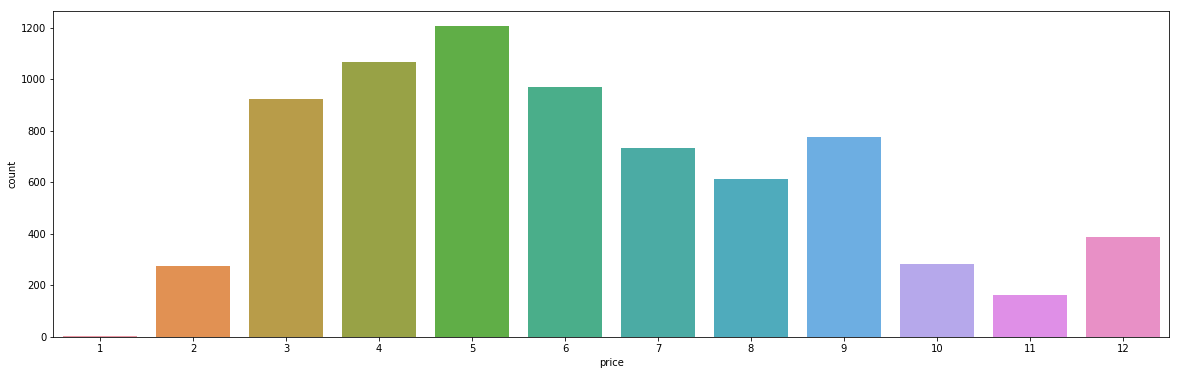

In [73]:
v_data = g_checkPoint.copy()
display(v_data['price'].describe())

v_bins = [item for item in range(0, 80, 10)]
v_bins.extend([item for item in range(80, 160, 20)])
v_bins = np.array(sorted(v_bins))
v_data['price'] = np.digitize(v_data['price'], v_bins, right = True)

plt.figure(figsize=(20, 6))
sns.countplot(x = v_data['price'])
plt.show()
g_checkPoint = v_data.copy()

Bin data for column << cleaning_fee >>.

count    7395.000000
mean       16.178093
std        22.183940
min         0.000000
25%         0.000000
50%        10.000000
75%        25.000000
max       400.000000
Name: cleaning_fee, dtype: float64

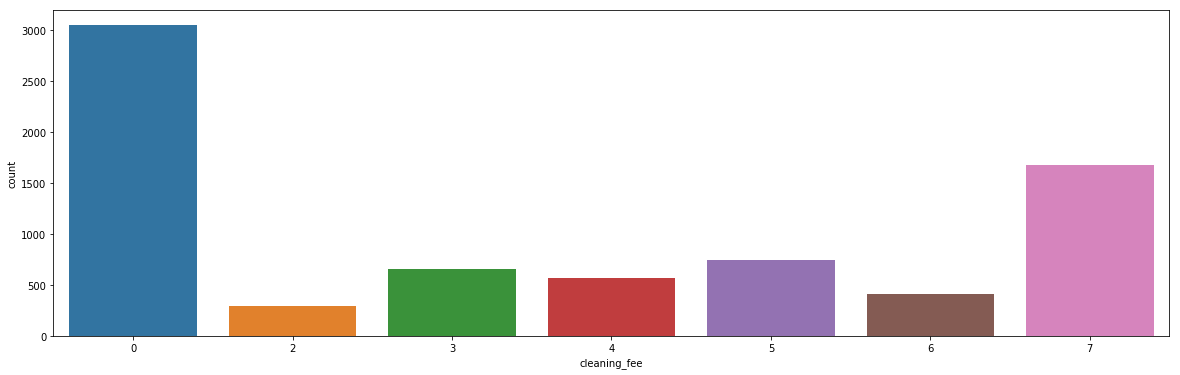

In [74]:
v_data = g_checkPoint.copy()
display(v_data['cleaning_fee'].describe())

v_bins = [0]
v_bins.extend([item for item in range(1, 30, 5)])
v_bins = np.array(sorted(v_bins))
v_data['cleaning_fee'] = np.digitize(v_data['cleaning_fee'], v_bins, right = True)

plt.figure(figsize=(20, 6))
sns.countplot(x = v_data['cleaning_fee'])
plt.show()
g_checkPoint = v_data.copy()

Bin data for column << security_deposit >>.

count    7395.000000
mean      108.562677
std       232.784206
min         0.000000
25%         0.000000
50%         0.000000
75%       150.000000
max      4744.000000
Name: security_deposit, dtype: float64

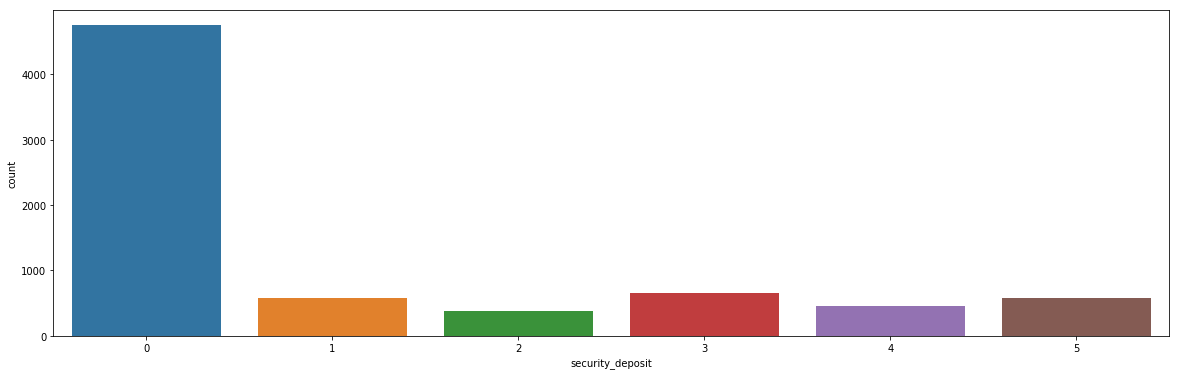

In [75]:
v_data = g_checkPoint.copy()
display(v_data['security_deposit'].describe())

v_bins = [0]
v_bins.extend([item for item in range(100, 450, 90)])
v_bins = np.array(sorted(v_bins))
v_data['security_deposit'] = np.digitize(v_data['security_deposit'], v_bins, right = True)

plt.figure(figsize=(20, 6))
sns.countplot(x = v_data['security_deposit'])
plt.show()
g_checkPoint = v_data.copy()

------------
### 4. Check all the columns that still have null values.

In [76]:
v_nunique = pd.DataFrame({ 'Unique Values':   v_data.nunique(), 
                           'Null Values':     v_data.isnull().sum(),
                           'Null Percentage': v_data.isnull().sum() / v_data.shape[0] }).T
display(v_nunique.loc[:, v_nunique.loc['Null Values'] != 0])

,name,summary,description,host_neighbourhood,neighbourhood,Host_Location_Country_American Samoa,Host_Location_Country_Argentina,Host_Location_Country_Australia,Host_Location_Country_Austria,Host_Location_Country_Belgium,Host_Location_Country_Brazil,Host_Location_Country_British Virgin Islands,Host_Location_Country_Brunei,Host_Location_Country_Buenos Aires,Host_Location_Country_Bulgaria,Host_Location_Country_Canada,Host_Location_Country_China,Host_Location_Country_Colombia,Host_Location_Country_Croatia,Host_Location_Country_Czech Republic,Host_Location_Country_Denmark,Host_Location_Country_Ecuador,Host_Location_Country_Egypt,Host_Location_Country_Estonia,Host_Location_Country_Finland,Host_Location_Country_France,Host_Location_Country_Germany,Host_Location_Country_Greece,Host_Location_Country_India,Host_Location_Country_Indonesia,Host_Location_Country_Ireland,Host_Location_Country_Israel,Host_Location_Country_Italy,Host_Location_Country_Jamaica,Host_Location_Country_Japan,Host_Location_Country_Kuwait,Host_Location_Country_Latvia,Host_Location_Country_Lebanon,Host_Location_Country_Luxembourg,Host_Location_Country_Mexico,Host_Location_Country_Moldavia,Host_Location_Country_Monaco,Host_Location_Country_Morocco,Host_Location_Country_Mozambique,Host_Location_Country_Netherlands,Host_Location_Country_Norway,Host_Location_Country_Panama,Host_Location_Country_Philippines,Host_Location_Country_Poland,Host_Location_Country_Portugal,Host_Location_Country_Republic of the Congo,Host_Location_Country_Reunion,Host_Location_Country_Romania,Host_Location_Country_Russia,Host_Location_Country_Rwanda,Host_Location_Country_Serbia,Host_Location_Country_Slovakia,Host_Location_Country_South Africa,Host_Location_Country_South Korea,Host_Location_Country_Spain,Host_Location_Country_Sweden,Host_Location_Country_Switzerland,Host_Location_Country_Taiwan,Host_Location_Country_Tunisia,Host_Location_Country_Turkey,Host_Location_Country_United Arab Emirates,Host_Location_Country_United Kingdom,Host_Location_Country_United States,Host_Location_Country_Unknown,Host_Location_Country_Venezuela,Host_Location_State_Auvergne-Rhone-Alpes,Host_Location_State_Bourgogne-Franche-Comte,Host_Location_State_Brittany,Host_Location_State_Bruxelles,Host_Location_State_Centre-Val de Loire,Host_Location_State_Corsica,Host_Location_State_Country District,Host_Location_State_Flanders,Host_Location_State_Grand Est,Host_Location_State_Hauts-de-France,Host_Location_State_Normandy,Host_Location_State_Nouvelle-Aquitaine,Host_Location_State_Occitanie,Host_Location_State_PACA,Host_Location_State_Pays de la Loire,Host_Location_State_Walloon Region,Host_Location_State_Île-de-France
Unique Values,7273.000000,6966.000000,7208.000000,90.000000,56.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
Null Values,14.000000,182.000000,69.000000,1350.000000,1.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.

In [77]:
v_data = g_checkPoint.copy()
v_exclude = [ 'name', 'summary',  'description', 
              #-----------------------------
             'host_neighbourhood', 'neighbourhood' ]
v_data.drop(v_exclude, axis = 1, inplace = True)
for item in v_data.select_dtypes(include = 'object').columns:
    v_values = v_data[item].value_counts()
    display(v_values.name)
    display(pd.DataFrame({'name': v_values.index.tolist(), 'values': v_values.values.tolist()}).T)

In [78]:
v_idx = v_data[v_data.isnull().any(axis = 1)].index.tolist()
v_data.drop(v_idx, inplace = True)

In [79]:
v_data.drop(['id', 'latitude', 'longitude'], axis = 1, inplace = True)

In [80]:
display(v_data.head(3))

,space,neighborhood_overview,notes,transit,access,interaction,house_rules,host_since,host_about,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,weekly_price diff,monthly_price diff,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,market_0.0,market_1.0,market_nan,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,room_type_nan,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_nan,property_type_Aparthotel,property_type_Apartment,...,Host_Location_Country_Brunei,Host_Location_Country_Buenos Aires,Host_Location_Country_Bulgaria,Host_Location_Country_Canada,Host_Location_Country_China,Host_Location_Country_Colombia,Host_Location_Country_Croatia,Host_Location_Country_Czech Republic,Host_Location_Country_Denmark,Host_Location_Country_Ecuador,Host_Location_Country_Egypt,Host_Location_Country_Estonia,Host_Location_Country_Finland,Host_Location_Country_France,Host_Location_Country_Germany,Host_Location_Country_Greece,Host_Location_Country_India,Host_Location_Country_Indonesia,Host_Location_Country_Ireland,Host_Location_Country_Israel,Host_Location_Country_Italy,Host_Location_Country_Jamaica,Host_Location_Country_Japan,Host_Location_Country_Kuwait,Host_Location_Country_Latvia,Host_Location_Country_Lebanon,Host_Location_Country_Luxembourg,Host_Location_Country_Mexico,Host_Location_Country_Moldavia,Host_Location_Country_Monaco,Host_Location_Country_Morocco,Host_Location_Country_Mozambique,Host_Location_Country_Netherlands,Host_Location_Country_Norway,Host_Location_Country_Panama,Host_Location_Country_Philippines,Host_Location_Country_Poland,Host_Location_Country_Portugal,Host_Location_Country_Republic of the Congo,Host_Location_Country_Reunion,Host_Location_Country_Romania,Host_Location_Country_Russia,Host_Location_Country_Rwanda,Host_Location_Country_Serbia,Host_Location_Country_Slovakia,Host_Location_Country_South Africa,Host_Location_Country_South Korea,Host_Location_Country_Spain,Host_Location_Country_Sweden,Host_Location_Country_Switzerland,Host_Location_Country_Taiwan,Host_Location_Country_Tunisia,Host_Location_Country_Turkey,Host_Location_Country_United Arab Emirates,Host_Location_Country_United Kingdom,Host_Location_Country_United States,Host_Location_Country_Unknown,Host_Location_Country_Venezuela,Host_Location_State_Auvergne-Rhone-Alpes,Host_Location_State_Bourgogne-Franche-Comte,Host_Location_State_Brittany,Host_Location_State_Bruxelles,Host_Location_State_Centre-Val de Loire,Host_Location_State_Corsica,Host_Location_State_Country District,Host_Location_State_Flanders,Host_Location_State_Grand Est,Host_Location_State_Hauts-de-France,Host_Location_State_Normandy,Host_Location_State_Nouvelle-Aquitaine,Host_Location_State_Occitanie,Host_Location_State_PACA,Host_Location_State_Pays de la Loire,Host_Location_State_Walloon Region,Host_Location_State_Île-de-France
0,1,1,1,1,1,0,1,125,1,1,0,3,3,0,0,0,5,1.0,2.0,2.0,0,9,2,7,4,5.0,2,220,4,3,19,49,229,14,57.0,16.0,86.0,9.0,9.0,9.0,9.0,8.0,9.0,1,1,0,3,0.27,0.960061,0.720000,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0

In [81]:
g_checkPoint = v_data.copy()

In [82]:
v_data = g_checkPoint.copy()
v_nunique = pd.DataFrame({ 'Unique Values':   v_data.nunique(), 
                           'Std':             v_data.std(),
                           'Min':             v_data.min(),
                           'Max':             v_data.max(),
                           'Null Percentage': v_data.isnull().sum() / v_data.shape[0] }).T
v_nunique = v_nunique.loc[:, ((v_nunique.loc['Unique Values'] > 2) & (v_nunique.loc['Std'] > 2))]
display(v_nunique)

display(v_nunique.columns)
v_scaler = {}
for item in v_nunique.columns:
    v_scaler[item] = StandardScaler().fit(v_data[[item]])
    v_data[item]   = v_scaler[item].transform(v_data[[item]])

,host_since,host_listings_count,host_total_listings_count,price,cleaning_fee,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
Unique Values,105.000000,35.000000,35.000000,12.000000,7.000000,49.000000,44.000000,88.00000,63.000000,31.000000,61.000000,91.000000,365.000000,294.000000,89.00000,62.000000,46.000000,11.000000,11.000000,11.00000,11.000000,10.00000,11.000000,28.000000,791.000000
Std,20.694592,60.014472,60.014472,2.618364,2.887544,10.528203,21.407003,90.30225,262.589865,10.224499,21.104442,32.357511,136.993694,48.147942,18.28143,10.243847,37.241927,3.822433,3.755041,3.85871,3.857144,3.75378,3.744299,12.417464,2.013939
Min,6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,1.000000,0.000000
Max,125.000000,930.000000,930.000000,12.000000,7.000000,241.000000,1000.000000,220.00000,1980.000000,30.000000,60.000000,90.000000,365.000000,546.000000,101.00000,98.000000,100.000000,10.000000,10.000000,10.00000,10.000000,10.00000,10.000000,69.000000,14.550000
Null Percentage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000


Index(['host_since', 'host_listings_count', 'host_total_listings_count',
       'price', 'cleaning_fee', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')

------------
### 5. **Q5**: Are there groups that have the same characteristics?

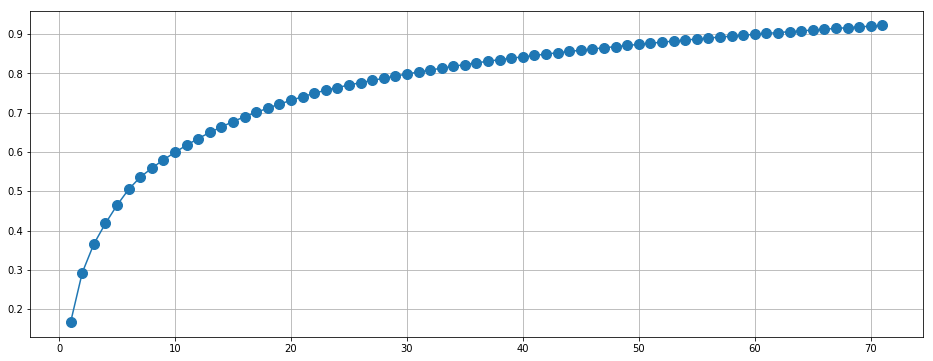

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
Cumulated Variance,0.1678,0.2932,0.3662,0.4186,0.4649,0.5052
Component Variance,0.1678,0.1254,0.0730,0.0524,0.0463,0.0403


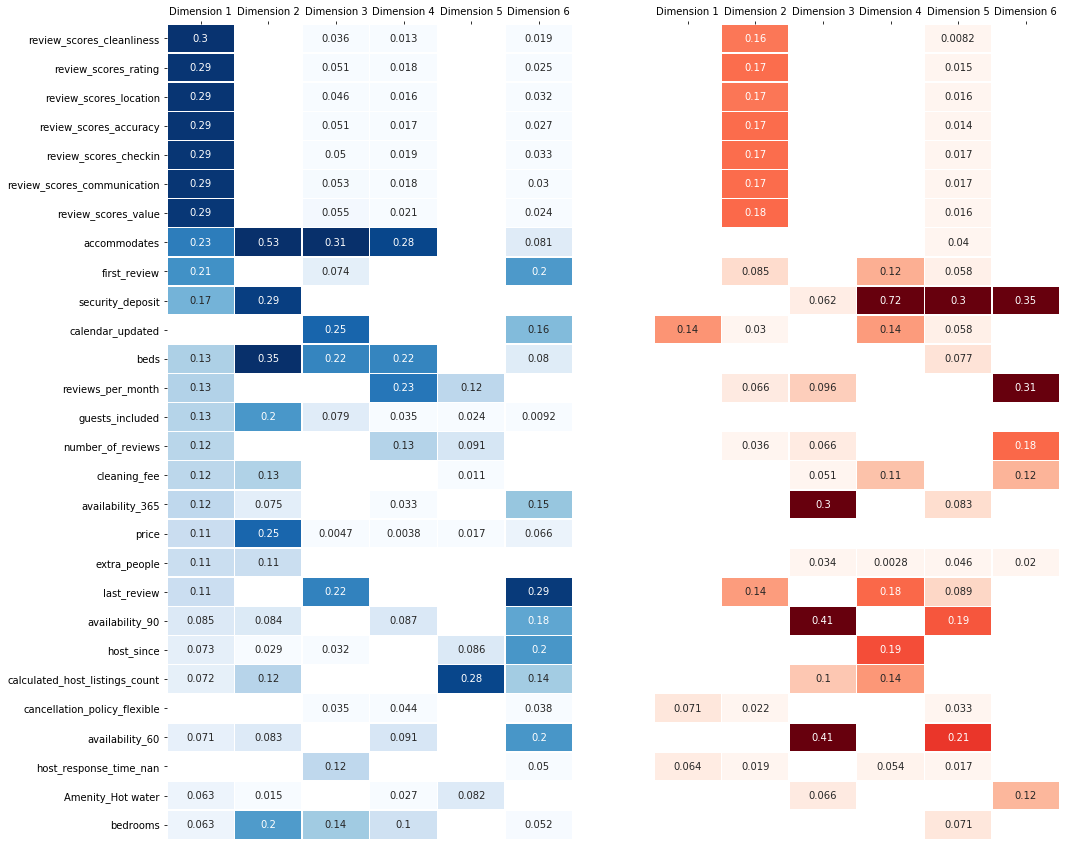

In [83]:
v_pca, X_pca = utl_executePCA(v_data, None, 0.92)
_, v_pcaComp = utl_displayPCAResults( p_data = v_data, 
                                      p_scaler = None,
                                      p_colName = 'Dimension ', 
                                      p_percent = 0.92, 
                                      p_comp_no = 6,
                                      p_no = 30 )

In [84]:
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import functools

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

from scipy.spatial.distance import cdist

g_random_state = np.random.RandomState(42)

def fitClusters(p_X, p_from, p_to):
    ''' Used to fit the KMeans for a different number of clusters
           - p_X - data to be fit
           - p_from - the lower bound for the number of clusters to be fit
           - p_to - the upper bound for the number of clusters to be fit '''
    kMeansVar = {}
    for key in range(p_from, p_to):
        kMeansVar[key] = KMeans( random_state = g_random_state,
                                 n_clusters = key, 
                                 precompute_distances = True,
                                 n_jobs = -1,
                                 n_init = 15,
                                 tol = 1e-3 ).fit(p_X)
        print(f'For {key} cluster(s) the sum of distances to the cluster center is {round(kMeansVar[key].inertia_, 2)}.')        
    return kMeansVar

kMeansVar = fitClusters(X_pca, 1, 14)

For 1 cluster(s) the sum of distances to the cluster center is 353948.76.
For 2 cluster(s) the sum of distances to the cluster center is 296006.69.
For 3 cluster(s) the sum of distances to the cluster center is 269051.25.
For 4 cluster(s) the sum of distances to the cluster center is 254578.84.
For 5 cluster(s) the sum of distances to the cluster center is 240647.42.
For 6 cluster(s) the sum of distances to the cluster center is 232893.34.
For 7 cluster(s) the sum of distances to the cluster center is 224279.29.
For 8 cluster(s) the sum of distances to the cluster center is 218184.29.
For 9 cluster(s) the sum of distances to the cluster center is 212185.23.
For 10 cluster(s) the sum of distances to the cluster center is 206999.48.
For 11 cluster(s) the sum of distances to the cluster center is 202183.67.
For 12 cluster(s) the sum of distances to the cluster center is 198810.03.
For 13 cluster(s) the sum of distances to the cluster center is 194516.83.


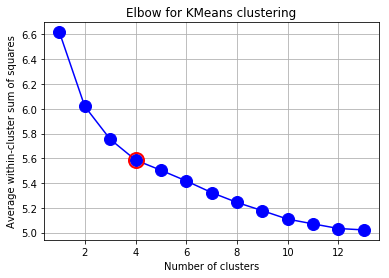

In [85]:
def elbowMethod(p_X, p_kMeansVar):
    ''' Used to plot / apply the elbow method for KMeans clusters
               - p_X - data to be fit
               - p_kMeansVar - different clusters that were already fitted for different number of clusters '''
    v_Key = list(p_kMeansVar.keys())
    centroids = [p_kMeansVar[key].cluster_centers_ for key in p_kMeansVar.keys()]
    D_k = [cdist(p_X, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D, axis = 1) for D in D_k]
    dist = [np.min(D, axis = 1) for D in D_k]
    avgWithinSS = [sum(d) / p_X.shape[0] for d in dist]

    seg_threshold = 0.98

    #The angle between points
    def segments_gain(p1, v, p2):
        vp1 = np.linalg.norm(p1 - v)
        vp2 = np.linalg.norm(p2 - v)
        p1p2 = np.linalg.norm(p1 - p2)
        return np.arccos((vp1**2 + vp2**2 - p1p2**2) / (2 * vp1 * vp2)) / np.pi

    #Normalize the data
    criterion = np.array(avgWithinSS)
    criterion = (criterion - criterion.min()) / (criterion.max() - criterion.min())

    #Compute the angles
    seg_gains = np.array([0, ] 
                  + [ segments_gain(*[np.array([v_Key[j], criterion[j]]) for j in range(i - 1, i + 2)]) 
                         for i in range(len(v_Key) - 2) ] + [0.1, ])

    #Get the first index satisfying the threshold
    kIdx = np.argmax(seg_gains > seg_threshold)

    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot( v_Key, avgWithinSS, 'b*-', marker = 'o', markersize = 12 )
    ax.plot( v_Key[kIdx], 
             avgWithinSS[kIdx], 
             marker = 'o', 
             markersize = 15, 
             markeredgewidth = 2, 
             markeredgecolor = 'r', 
             markerfacecolor = 'None' )
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    return
    
elbowMethod(X_pca, kMeansVar)

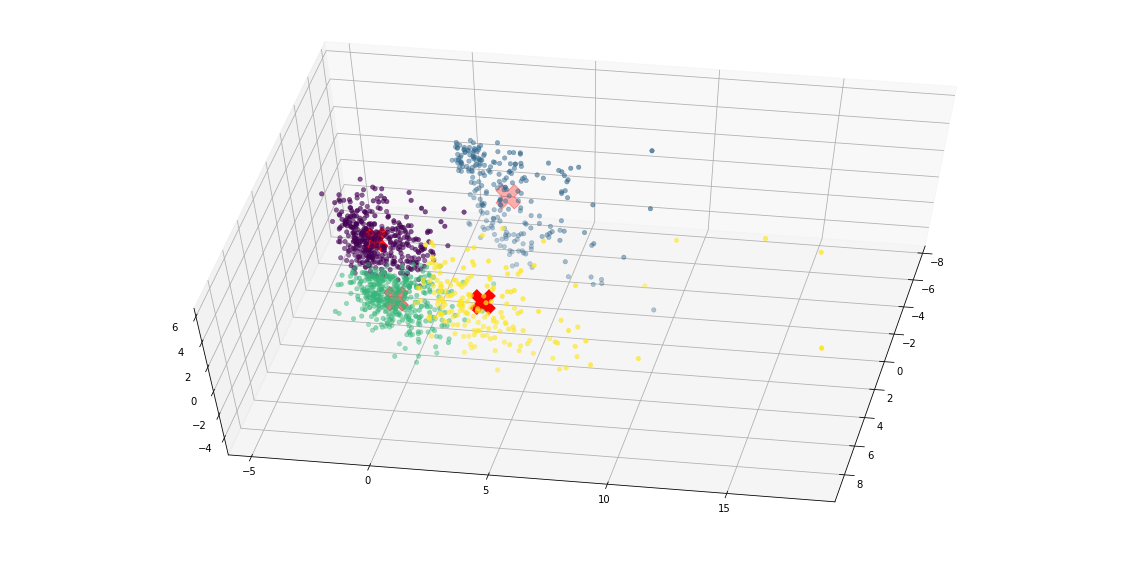

In [86]:
g_clusterNo = 4

def getKMeanLabels(p_X, p_kMeansVar, p_n_clusters, p_gapNo):
    labels    = p_kMeansVar[p_n_clusters].predict(p_X)
    centroids = p_kMeansVar[p_n_clusters].cluster_centers_
    
    v_data = np.array([0 for i in range(p_X.shape[1])])
    v_labels = np.array([0])
    for n_cluster in range(p_n_clusters):
        v_x = p_X[labels == n_cluster]    
        v_centroid = centroids[n_cluster].reshape(1, -1)
        
        v_x = np.append(v_x, cdist(v_x, v_centroid, 'euclidean'), axis = 1)
        v_x = v_x[v_x[:, -1].argsort()] # Sort by the distances to the centroid
        v_x = v_x[1::p_gapNo, :] # Select every ith element
        v_x = v_x[:, :-1]
        
        v_label = np.full((v_x.shape[0], 1), n_cluster)        
        v_data = np.vstack((v_data, v_x))
        v_labels = np.vstack((v_labels, v_label)) 
        
    return v_data, v_labels

v_centroids = kMeansVar[g_clusterNo].cluster_centers_
v_kmeanData, v_labels = getKMeanLabels(X_pca, kMeansVar, g_clusterNo, 6) 

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111, projection='3d', elev = 60, azim = 10)
ax.scatter( v_kmeanData[:, 0:1], 
            v_kmeanData[:, 1:2], 
            v_kmeanData[:, 2:3], 
            c = v_labels.ravel(), cmap = 'viridis', linewidth = 0.5 )
ax.scatter( v_centroids[:, 0:1], 
            v_centroids[:, 1:2], 
            v_centroids[:, 2:3], 
            s = 600, marker = 'X', color = 'r', linewidth = 1 )
plt.show()

In [87]:
for ith_cluster in range(g_clusterNo):
    ith_lbl = v_labels[v_labels == ith_cluster]    
    ith_lbl_per = round(ith_lbl.shape[0] / v_labels.shape[0] * 100, 2)
    print(f'Proportion of data for cluster {ith_cluster + 1}: {round(ith_lbl_per, 2)} ({ith_lbl.shape[0]}).')

Proportion of data for cluster 1: 32.6 (401).
Proportion of data for cluster 2: 19.11 (235).
Proportion of data for cluster 3: 32.6 (401).
Proportion of data for cluster 4: 15.69 (193).


In [88]:
v_cluster = v_pca.inverse_transform(X_pca)  
v_cluster = pd.DataFrame(v_cluster, columns = v_data.columns, index = v_data.index)  
for item in v_scaler.keys():
    v_cluster[item] = np.round(v_scaler[item].inverse_transform(v_cluster[[item]]))
v_cluster['cluster'] = kMeansVar[g_clusterNo].predict(X_pca)
v_cluster = np.abs(np.round(v_cluster))

v_nunique = pd.DataFrame({ 'Unique Values':   v_cluster.nunique(), 
                           'Std':             v_cluster.std(),
                           'Min':             v_cluster.min(),
                           'Max':             v_cluster.max() }).T
v_cluster.drop(v_nunique.loc[:, v_nunique.loc['Unique Values'] == 1].columns, axis = 1, inplace = True)

In [89]:
v_df = pd.DataFrame()
for cluster in sorted(v_cluster['cluster'].value_counts().index):
    for column in v_cluster.columns:
        v_values        = np.round(v_cluster[v_cluster['cluster'] == cluster][column]).value_counts()
        v_values = pd.DataFrame({ 'Cluster':    str(cluster), 
                                  'Column':     column, 
                                  'Values':     v_values.index,
                                  'Values No':  v_values })
        v_values['Values %'] = round(v_values['Values No'] / v_cluster[v_cluster['cluster'] == cluster].shape[0], 2)
        v_df = v_df.append(v_values, ignore_index = True)

Select only the columns that have for a given value a procent bigger than 0.10 for all clusters, have the sum of the percentages around all clusters different than the number of clusters (which means that at least one cluster has for a given value a percentage different than 1).

Number of feature - values pairs where we have a global difference is: 37


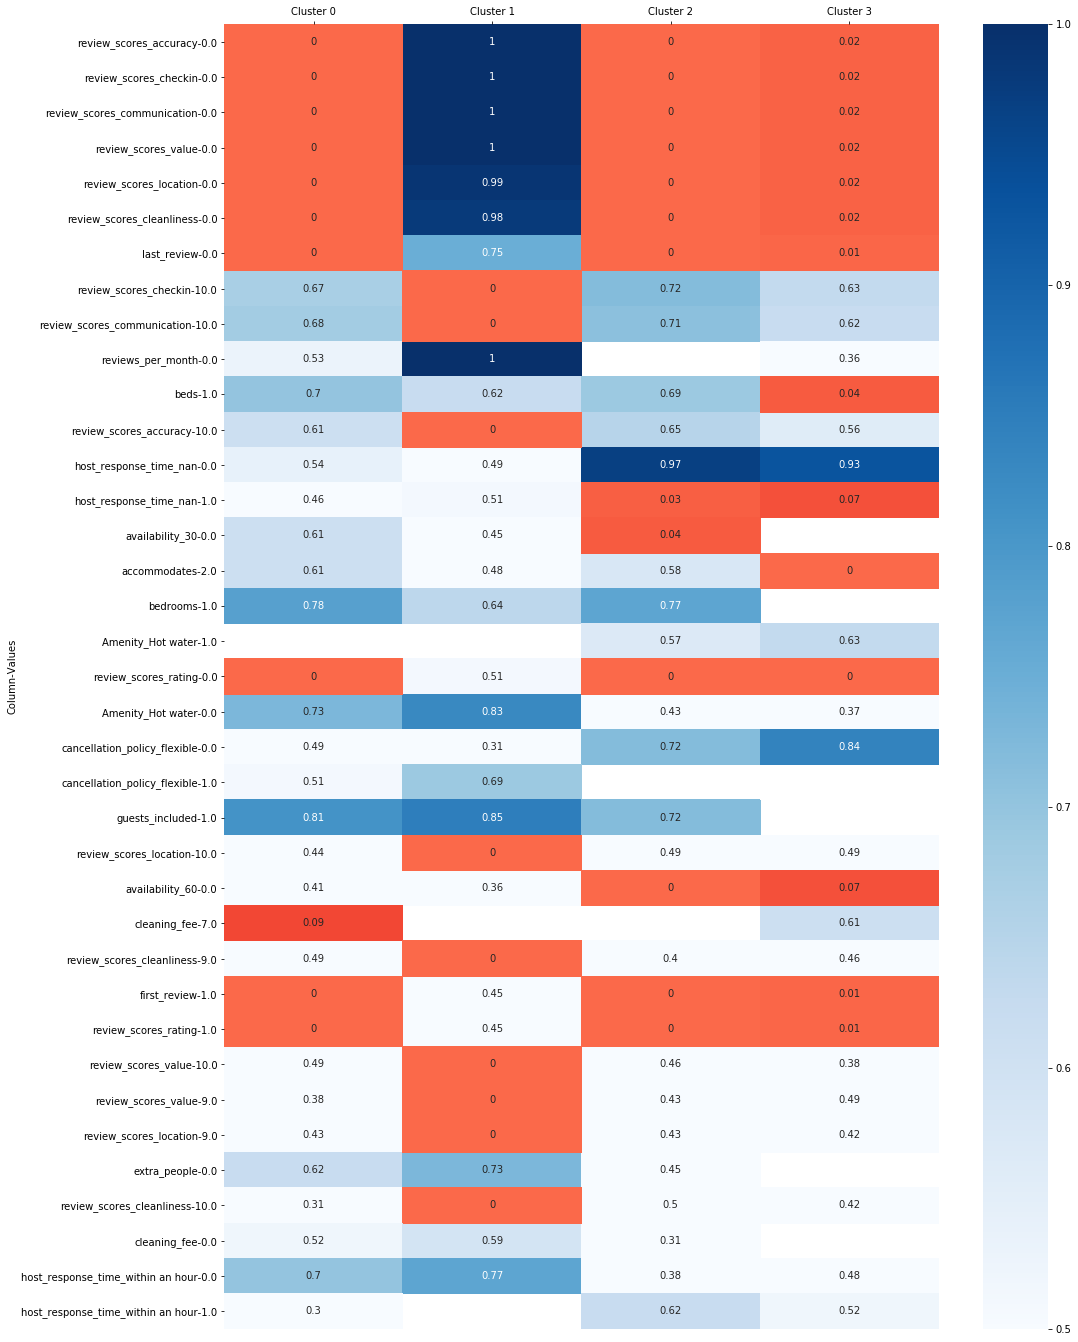

In [90]:
v_group = (pd.pivot_table(v_df, index = ['Cluster', 'Column'], columns = ['Values'], values = ['Values %']))
v_group = (pd.pivot_table(v_df, index = ['Column', 'Values'], columns = ['Cluster'], values = ['Values %'])).fillna(0)
v_group.columns = [f'Cluster {item[0]}' for item in v_group.columns.droplevel(level = 0).tolist()]
v_group.drop(['cluster'], axis = 0, inplace = True)
v_cols = v_group.columns

v_group['Sum'] = v_group.sum(axis = 1)
v_group = v_group[(v_group['Sum'] > 0.10) & (v_group['Sum'] != g_clusterNo)].drop(['Sum'], axis = 1).copy()

v_group['Mean'] = v_group.mean(axis = 1)
for item in v_cols:
    v_group[f'{item} Diff'] = np.abs(v_group[item] - v_group['Mean']).apply(lambda x: 0 if x < 0.03 else x)

v_group['Sum'] = v_group[[item for item in v_group.columns if 'Diff' in item]].sum(axis = 1)
v_group.reset_index(inplace = True)
v_group = v_group[(v_group['Sum'] > 0.60)].copy().sort_values(['Sum', 'Column', 'Values'], ascending = [False, True, True])
v_group.set_index(['Column', 'Values'], inplace = True)

print(f'Number of feature - values pairs where we have a global difference is: {v_group[v_cols].shape[0]}')
fig, ax = plt.subplots(figsize=(16, 24))
sns.heatmap( v_group[v_cols], 
             mask = ((v_group[v_cols] < 0.30) & (v_group[v_cols] > 0.10)), 
             annot = True, cmap = "Blues", vmin = 0.50, ax = ax )
sns.heatmap( v_group[v_cols], 
             mask = (v_group[v_cols] > 0.10), 
             cmap = "Reds", vmin = -0.5, vmax = 0.5, cbar = False )
ax.xaxis.tick_top()
plt.show()

We can see that 4 clusters can explain the complete dataset for the Airbnb data in Brussels, and in the figure above we can find the main features. 